<a href="https://colab.research.google.com/github/sinaabbasi1/NLP-MSc/blob/main/Assignments/Assignment%2004/NLP_Assignment_04_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable AI

This assignment focuses on *Explainable AI*, which involves understanding and interpreting the decisions and predictions made by AI models. The goal is to provide transparency and insights into how these models operate, allowing users to trust, verify, and comprehend their behavior.  Your task is to implement an Explainable AI methods in NLP.

Steps to take for completing this assignment:

* First, fine-tune the RoBERTa model on [this](https://huggingface.co/datasets/cornell-movie-review-data/rotten_tomatoes) dataset.
* Then, read [this](https://arxiv.org/abs/1703.01365) paper.
* Finally, implement Integrated Gradient method for your fine-tuned model.


# Prerequisites

First, we install and import libraries we'll need later.

In [ ]:
!pip install datasets
!pip install transformers
# Package `portalocker` is required to be installed to use this datapipe
!pip install 'portalocker>=2.0.0'

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from transformers import RobertaModel, RobertaTokenizer
from transformers import AutoTokenizer, GPT2Config, PreTrainedModel
from transformers import AutoModelForCausalLM, PretrainedConfig, AutoConfig, AutoModel, AutoImageProcessor

import torchtext.datasets as datasets

import os, math
import numpy as np
from tqdm.notebook import tqdm
import random
import copy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import clear_output

clear_output()

Next, we'll set the random seeds for reproducability.

In [ ]:
SEED = 43

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Setting the device option:

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# The Data

In this exercise we are going to use the Rotten Tomatoes Movie Review Dataset. This is a dataset of containing 5,331 positive and 5,331 negative processed sentences from Rotten Tomatoes movie reviews.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("rotten_tomatoes")
clear_output()

## Data fields

*   *text:* a string feature.
*   *label:* a classification label, with possible values including neg (0), pos (1).

You can see the number of rows in each split of the data.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

Defining some key variables that will be used later on in the training.

In [ ]:
# maximum length in the whole dataset is 80
MAX_LEN = 80
BATCH_SIZE = 32
LR = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
clear_output()

In [ ]:
class RottenDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = data
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data[index]['text'])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.data[index]['label'], dtype=torch.float)
        }

In [ ]:
train_dataset = RottenDataset(dataset['train'], tokenizer, MAX_LEN)
valid_dataset = RottenDataset(dataset['validation'], tokenizer, MAX_LEN)
test_dataset = RottenDataset(dataset['test'], tokenizer, MAX_LEN)

In [ ]:
len(train_dataset)

8530

Here we define our dataloaders:

In [ ]:
train_dataloader = data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=False)
valid_dataloader = data.DataLoader(valid_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=False)
test_dataloader = data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=False)

# The Model

The model we are going to use is RoBERTa.

In [ ]:
# Defining RoBERTa model and adding classfication head on top of it
class RobertaClass(nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.bare_roberta = RobertaModel.from_pretrained("roberta-base")
        self.dense = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        try:
            output_1 = self.bare_roberta(inputs_embeds=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        except:
            output_1 = self.bare_roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)

        hidden_state = output_1[0] # last_hidden_state (batch_size, sequence_length, hidden_size)
        pooler = hidden_state[:, 0] # take only the CLS token from last_hidden_state
        # pooler = hidden_state[:, 1:].mean(1)
        pooler = self.dense(pooler)
        pooler = nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output, output_1

In [ ]:
model = RobertaClass()
model.to(device)

# Fine-tuning

Here we fine-tune the generated model from previous section.

In [ ]:
# Defining the loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [ ]:
# Accuracy function
def calculate_accuracy(preds, targets):
    n_correct = (preds==targets).sum().item()
    return n_correct

In [ ]:
def train_model(model, optimizer, data_loader, dataset, criterion):
    # Set model to train mode
    model.train()

    # loss per epoch and number of correct predictions in order to calculate the accuracy
    epoch_loss = 0
    n_correct = 0

    for data in tqdm(data_loader, desc='Training', leave=False):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        ## Step 2: Run the model on the input data
        preds, _ = model(ids, mask, token_type_ids)

        ## Step 3: Calculate the loss and accuracy
        loss = criterion(preds, targets)

        max_val, max_idx = torch.max(preds.data, dim=1)
        n_correct += calculate_accuracy(max_idx, targets)

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(data_loader), (n_correct / len(dataset))

In [ ]:
def eval_model(model, data_loader, dataset, criterion):
    # Set model to eval mode
    model.eval()

    # loss per epoch and number of correct predictions in order to calculate the accuracy
    epoch_loss = 0
    n_correct = 0
    preds_list = list()
    targets_list = list()

    with torch.no_grad(): # Deactivate gradients for the following code
        for data in tqdm(data_loader, desc='Evaluation', leave=False):

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            # print(targets.tolist())
            targets_list.extend(targets.tolist())

            ## Step 2: Run the model on the input data
            preds, _ = model(ids, mask, token_type_ids)
            preds = preds.squeeze()
            # print(preds.tolist())
            preds_list.extend(preds.tolist())

            ## Step 3: Calculate the loss and accuracy
            loss = criterion(preds, targets)

            max_val, max_idx = torch.max(preds.data, dim=1)
            n_correct += calculate_accuracy(max_idx, targets)

            epoch_loss += loss.item()

    return epoch_loss / len(data_loader), (n_correct / len(dataset)), preds_list, targets_list

In [ ]:
EPOCHS = 6

best_valid_loss = float('inf')

# Training loop
for epoch in tqdm(range(EPOCHS), desc='Epochs'):

    train_loss, train_acc = train_model(model, optimizer, train_dataloader, train_dataset, criterion)
    valid_loss, valid_acc, _, _ = eval_model(model, valid_dataloader, valid_dataset, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'name_of_chackpoint.pt')

    print(f'Epoch: {epoch + 1:02}')
    print(f'\tTrain loss: {train_loss:.3f} | Train acc: {train_acc * 100:.2f}%')
    print(f'\tValid loss: {valid_loss:.3f} | Valid acc: {valid_acc * 100:.2f}%')

# Evaluation

Now, we evaluate the performance of the fine-tuned model on the test set by computing metrics like accuracy, precision, recall, and F1-score. First we load the best checkpoint:

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP 01 - Dr. Pilehvar/checkpoint_Rotten_RoBERTa.pt'))

<All keys matched successfully>

## Accuracy

In [ ]:
test_loss, test_acc, preds_list, targets_list = eval_model(model, test_dataloader, test_dataset, criterion)
print(f'Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}%')

Evaluation:   0%|          | 0/34 [00:00<?, ?it/s]

Test loss: 0.308 | Test acc: 87.52%


Using torchmetrics to calculate remaining metrics.

In [ ]:
!pip install torchmetrics
clear_output()

In [ ]:
from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryF1Score

In [ ]:
# generated prediction and target lists are correct in size
print(len(preds_list))
print(len(targets_list))

1066
1066


In [ ]:
# torchmetrics uses tensors
preds_tensor = torch.tensor(preds_list)
targets_tensor = torch.tensor(targets_list)

In [ ]:
# max for each prediction
preds_tensor_max = torch.max(preds_tensor, 1)

## Precision

In [ ]:
precision_metric = BinaryPrecision()
precision = precision_metric(preds_tensor_max.indices, targets_tensor).item()
print(f'Precision: {precision * 100:.2f}%')

Precision: 90.16%


## Recall

In [ ]:
recall_metric = BinaryRecall()
recall = recall_metric(preds_tensor_max.indices, targets_tensor).item()
print(f'Recall: {recall * 100:.2f}%')

Recall: 84.24%


## F-1 Score

In [ ]:
f1score_metric = BinaryF1Score()
f1score = f1score_metric(preds_tensor_max.indices, targets_tensor)
print(f'F-1 Score: {f1score * 100:.2f}%')

F-1 Score: 87.10%


# Integrated Gradients

In this part we get model outputs for 10 examples of the test set. First, we define our Integrated Gradients function. Here you see two versions of it:

*   `integrated_gradients`: Interpolation solely on embeddings of input text
*   `integrated_gradients_whole`: Interpolation on whole embedding matrix


Both, give us the same result.


In [ ]:
def integrated_gradients(data, model, num_steps):

    model.eval()
    # get the word embedding matrix, we are gonna change the input in order to use different steps, each time we need to modify
    # embeddings from original_embed. Because of that, we make a deepcopy of it.
    num_layers = 12

    ids = data['ids'].to(device, dtype = torch.long)

    embedding_layer = model.bare_roberta.get_input_embeddings()
    embeddings = embedding_layer(ids)
    orig_embeddings = copy.deepcopy(embeddings.data)

    # We make our baseline. It contains zeros in the shape of input tensor
    baseline = torch.zeros_like(orig_embeddings)

    all_layers_gradients = list() # Gradients of each step will record in this list

    for layer in tqdm(range(0, num_layers)):

        gradients = list()
        for step in tqdm(range(1, num_steps + 1)):

            alpha = step / num_steps # alpha = k / m

            embeddings.data = baseline + (alpha * (orig_embeddings - baseline))  #interpolation

            # creating the data attention_mask and token_type_id
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

            preds, bare_roberta_output = model(embeddings, mask, token_type_ids)

            # The hidden layer which we want to compute the gradient on
            goal_hidden_layer = bare_roberta_output.hidden_states[layer] # for example 1th hidden layer

            max_logit = torch.max(preds, dim=1).values

            goal_hidden_layer.grad = None
            step_gradient = torch.autograd.grad(max_logit.sum(),
                                                goal_hidden_layer,
                                                retain_graph=True,
                                                create_graph=True
                                                )

            # We need gradients of different steps
            gradients.append(step_gradient[0].tolist())
        all_layers_gradients.append(gradients)

    # consider we have [batch_size, num_steps, max_length, 768] -> mean(1) is acting as sigma and 1/m and output will
    # be [batch_size, max_length, 768]
    average_grads = torch.tensor(all_layers_gradients, dtype=torch.float32).mean(1).to(device)

    # We need to compute integrated_grads for each layer
    integrated_grads = list()
    for layer in range(num_layers):
        goal_hidden_layer = bare_roberta_output.hidden_states[0]
        # goal_hidden_layer = orig_embeddings
        # goal_hidden_layer = bare_roberta_output.hidden_states[layer]
        integrated_grads.append(goal_hidden_layer * average_grads[layer])

    predicted_labels = torch.max(preds, dim=1).indices.tolist() # List of 0 and 1

    return integrated_grads, predicted_labels

In [ ]:
def integrated_gradients_whole(data, model, num_steps):

    model.eval()
    # get the word embedding matrix, we are gonna change the input in order to use different steps, each time we need to modify
    # embeddings from original_embed. Because of that, we make a deepcopy of it.
    num_layers = 12

    input = model.bare_roberta.embeddings.word_embeddings.weight
    orig_input = copy.deepcopy(input.data)

    # We make our baseline. It contains zeros in the shape of input tensor
    baseline = torch.zeros_like(orig_input)

    all_layers_gradients = list() # Gradients of each step will record in this list

    for layer in tqdm(range(0, num_layers)):

        gradients = list()
        for step in tqdm(range(1, num_steps + 1)):

            alpha = step / num_steps # alpha = k / m

            input.data = baseline + (alpha * (orig_input - baseline)) #interpolation

            # creating the data input_ids, attention_mask, and token_type_id
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

            preds, bare_roberta_output = model(ids, mask, token_type_ids)

            # The hidden layer which we want to compute the gradient on
            goal_hidden_layer = bare_roberta_output.hidden_states[layer] # for example 1th hidden layer

            max_logit = torch.max(preds, dim=1).values

            step_gradient = torch.autograd.grad(max_logit.sum(),
                                                goal_hidden_layer,
                                                retain_graph=True,
                                                create_graph=True
                                                )

            # We need gradients of different steps
            gradients.append(step_gradient[0].tolist())
        all_layers_gradients.append(gradients)

    # consider we have [batch_size, num_steps, max_length, 768] -> mean(1) is acting as sigma and 1/m and output will
    # be [batch_size, max_length, 768]
    average_grads = torch.tensor(all_layers_gradients, dtype=torch.float32).mean(1).to(device)

    # We need to compute integrated_grads for each layer
    integrated_grads = list()
    for layer in range(num_layers):
        goal_hidden_layer = bare_roberta_output.hidden_states[0]
        # goal_hidden_layer = bare_roberta_output.hidden_states[layer]
        integrated_grads.append(goal_hidden_layer * average_grads[layer])

    predicted_labels = torch.max(preds, dim=1).indices.tolist() # List of 0 and 1

    return integrated_grads, predicted_labels


We pick a batch of test_data in order to compute the attributions for it.

In [ ]:
# 32 samples
data = next(iter(test_dataloader))

***NOTE:*** Because of limitations of the memory we are gonna compute our attributions in batches of size 2.

In [ ]:
data_1 = dict()
data_1['ids'], data_1['mask'], data_1['token_type_ids'], data_1['targets'] = data['ids'][0:2], data['mask'][0:2], data['token_type_ids'][0:2], data['targets'][0:2]

In [ ]:
data_2 = dict()
data_2['ids'], data_2['mask'], data_2['token_type_ids'], data_2['targets'] = data['ids'][2:4], data['mask'][2:4], data['token_type_ids'][2:4], data['targets'][2:4]

In [ ]:
data_3 = dict()
data_3['ids'], data_3['mask'], data_3['token_type_ids'], data_3['targets'] = data['ids'][4:6], data['mask'][4:6], data['token_type_ids'][4:6], data['targets'][4:6]

In [ ]:
data_4 = dict()
data_4['ids'], data_4['mask'], data_4['token_type_ids'], data_4['targets'] = data['ids'][6:8], data['mask'][6:8], data['token_type_ids'][6:8], data['targets'][6:8]

In [ ]:
data_5 = dict()
data_5['ids'], data_5['mask'], data_5['token_type_ids'], data_5['targets'] = data['ids'][8:10], data['mask'][8:10], data['token_type_ids'][8:10], data['targets'][8:10]

In [ ]:
data_1['ids'].shape

torch.Size([2, 80])

Now, we call the function on test data.

#### Step = 1

In [ ]:
integ_grad_data_1_step_1, lbl_data_1_step_1 = integrated_gradients(data=data_1, model=model, num_steps=1)
clear_output()

In [ ]:
integ_grad_data_2_step_1, lbl_data_2_step_1 = integrated_gradients(data=data_2, model=model, num_steps=1)
clear_output()

In [ ]:
integ_grad_data_3_step_1, lbl_data_3_step_1 = integrated_gradients(data=data_3, model=model, num_steps=1)
clear_output()

In [ ]:
integ_grad_data_4_step_1, lbl_data_4_step_1 = integrated_gradients(data=data_4, model=model, num_steps=1)
clear_output()

In [ ]:
integ_grad_data_5_step_1, lbl_data_5_step_1 = integrated_gradients(data=data_5, model=model, num_steps=1)
clear_output()

#### Step = 10

In [ ]:
integ_grad_data_1_step_10, lbl_data_1_step_10 = integrated_gradients(data=data_1, model=model, num_steps=10)
clear_output()

In [ ]:
integ_grad_data_2_step_10, lbl_data_2_step_10 = integrated_gradients(data=data_2, model=model, num_steps=10)
clear_output()

In [ ]:
integ_grad_data_3_step_10, lbl_data_3_step_10 = integrated_gradients(data=data_3, model=model, num_steps=10)
clear_output()

In [ ]:
integ_grad_data_4_step_10, lbl_data_4_step_10 = integrated_gradients(data=data_4, model=model, num_steps=10)
clear_output()

In [ ]:
integ_grad_data_5_step_10, lbl_data_5_step_10 = integrated_gradients(data=data_5, model=model, num_steps=10)
clear_output()

#### Step = 100

In [ ]:
integ_grad_data_1_step_100, lbl_data_1_step_100 = integrated_gradients(data=data_1, model=model, num_steps=100)
clear_output()

In [ ]:
integ_grad_data_2_step_100, lbl_data_2_step_100 = integrated_gradients(data=data_2, model=model, num_steps=100)
clear_output()

In [ ]:
integ_grad_data_3_step_100, lbl_data_3_step_100 = integrated_gradients(data=data_3, model=model, num_steps=100)
clear_output()

In [ ]:
integ_grad_data_4_step_100, lbl_data_4_step_100 = integrated_gradients(data=data_4, model=model, num_steps=100)
clear_output()

In [ ]:
integ_grad_data_5_step_100, lbl_data_5_step_100 = integrated_gradients(data=data_5, model=model, num_steps=100)
clear_output()

#### Step = 300

Because of the memory limitations we use each data sample as a single batch. `data_1` through `data_10` indicate these batches.

In [ ]:
data_1 = dict()
data_1['ids'], data_1['mask'], data_1['token_type_ids'], data_1['targets'] = data['ids'][0:1], data['mask'][0:1], data['token_type_ids'][0:1], data['targets'][0:1]

In [ ]:
data_2 = dict()
data_2['ids'], data_2['mask'], data_2['token_type_ids'], data_2['targets'] = data['ids'][1:2], data['mask'][1:2], data['token_type_ids'][1:2], data['targets'][1:2]

In [ ]:
data_3 = dict()
data_3['ids'], data_3['mask'], data_3['token_type_ids'], data_3['targets'] = data['ids'][2:3], data['mask'][2:3], data['token_type_ids'][2:3], data['targets'][2:3]

In [ ]:
data_4 = dict()
data_4['ids'], data_4['mask'], data_4['token_type_ids'], data_4['targets'] = data['ids'][3:4], data['mask'][3:4], data['token_type_ids'][3:4], data['targets'][3:4]

In [ ]:
data_5 = dict()
data_5['ids'], data_5['mask'], data_5['token_type_ids'], data_5['targets'] = data['ids'][4:5], data['mask'][4:5], data['token_type_ids'][4:5], data['targets'][4:5]

In [ ]:
data_6 = dict()
data_6['ids'], data_6['mask'], data_6['token_type_ids'], data_6['targets'] = data['ids'][5:6], data['mask'][5:6], data['token_type_ids'][5:6], data['targets'][5:6]

In [ ]:
data_7 = dict()
data_7['ids'], data_7['mask'], data_7['token_type_ids'], data_7['targets'] = data['ids'][6:7], data['mask'][6:7], data['token_type_ids'][6:7], data['targets'][6:7]

In [ ]:
data_8 = dict()
data_8['ids'], data_8['mask'], data_8['token_type_ids'], data_8['targets'] = data['ids'][7:8], data['mask'][7:8], data['token_type_ids'][7:8], data['targets'][7:8]

In [ ]:
data_9 = dict()
data_9['ids'], data_9['mask'], data_9['token_type_ids'], data_9['targets'] = data['ids'][8:9], data['mask'][8:9], data['token_type_ids'][8:9], data['targets'][8:9]

In [ ]:
data_10 = dict()
data_10['ids'], data_10['mask'], data_10['token_type_ids'], data_10['targets'] = data['ids'][9:10], data['mask'][9:10], data['token_type_ids'][9:10], data['targets'][9:10]

For each of these datas we need to compute Integrated Gradients:

In [ ]:
integ_grad_data_1_step_300, lbl_data_1_step_300 = integrated_gradients(data=data_1, model=model, num_steps=300)
clear_output()

In [ ]:
integ_grad_data_2_step_300, lbl_data_2_step_300 = integrated_gradients(data=data_2, model=model, num_steps=300)
clear_output()

In [ ]:
integ_grad_data_3_step_300, lbl_data_3_step_300 = integrated_gradients(data=data_3, model=model, num_steps=300)
clear_output()

In [ ]:
integ_grad_data_4_step_300, lbl_data_4_step_300 = integrated_gradients(data=data_4, model=model, num_steps=300)
clear_output()

In [ ]:
integ_grad_data_5_step_300, lbl_data_5_step_300 = integrated_gradients(data=data_5, model=model, num_steps=300)
clear_output()

In [ ]:
integ_grad_data_6_step_300, lbl_data_6_step_300 = integrated_gradients(data=data_6, model=model, num_steps=300)
clear_output()

In [ ]:
integ_grad_data_7_step_300, lbl_data_7_step_300 = integrated_gradients(data=data_7, model=model, num_steps=300)
clear_output()

In [ ]:
integ_grad_data_8_step_300, lbl_data_8_step_300 = integrated_gradients(data=data_8, model=model, num_steps=300)
clear_output()

In [ ]:
integ_grad_data_9_step_300, lbl_data_9_step_300 = integrated_gradients(data=data_9, model=model, num_steps=300)
clear_output()

In [ ]:
integ_grad_data_10_step_300, lbl_data_10_step_300 = integrated_gradients(data=data_10, model=model, num_steps=300)
clear_output()

# Visualization

`hmap_visualization` defined for visualization and `sub_counter` defined in order to adding some counter for redundant tokens in the sequence. Also, we delete the `Ġ` symbol from the start of each token in order to enhance the readibility.

In [ ]:
# this function returns the number of elements in a list of string contains some specific substirng
def sub_counter(string_list, substring):
    # Initialize a counter variable
    count = 0

    # Loop over the list of strings
    for string in string_list:
        # Check if the substring is present in the string
        if substring in string:
            # If the substring is present, increment the counter
            count += 1

    return count

In [ ]:
def hmap_visualization(data, data_idx, integ_grad, lbl):
    # We have a list contains of all tokens, and for each token we have a list that contains its scores in 12 different layers
    d = [[] for i in range(len(['<s>'] + tokenizer.convert_ids_to_tokens(data['ids'][data_idx], True) + ['</s>']))]

    for layer in range(len(integ_grad)):
        scores = torch.sqrt((integ_grad[layer][data_idx] ** 2).sum(-1))
        max_score = torch.max(scores, dim=0).values
        min_score = torch.min(scores, dim=0).values
        scores = (scores - min_score) / (max_score - min_score)
        for i in range(len(d)):
            d[i].append(scores[i].item())

    # Now we convert our list to a dictionary
    # But we are going to delete Ġ symbol from the start of each token in order to enhance the readibility
    dic = dict()
    for idx, k in enumerate(['<s>'] + tokenizer.convert_ids_to_tokens(data['ids'][data_idx], True) + ['</s>']):
        if k.startswith('Ġ'):
            if k[1:] in dic.keys():
                dic[k[1:] + f'(+{sub_counter(dic.keys(), k[1:])})'] = d[idx]
            else:
                dic[k[1:]] = d[idx]
        else:
            if k in dic.keys():
                dic[k + f'(+{sub_counter(dic.keys(), k)})'] = d[idx]
            else:
                dic[k] = d[idx]

    df = pd.DataFrame.from_dict(dic)

    plt.figure(figsize = (12, 5))

    if lbl[data_idx] == 0:
        plt.title(tokenizer.decode(data['ids'][data_idx], skip_special_tokens=True) + ' ---> Negative')
    else:
        plt.title(tokenizer.decode(data['ids'][data_idx], skip_special_tokens=True) + ' ---> Positive')

    sns.heatmap(df.iloc[::-1], cmap='Reds')

#### Step = 1

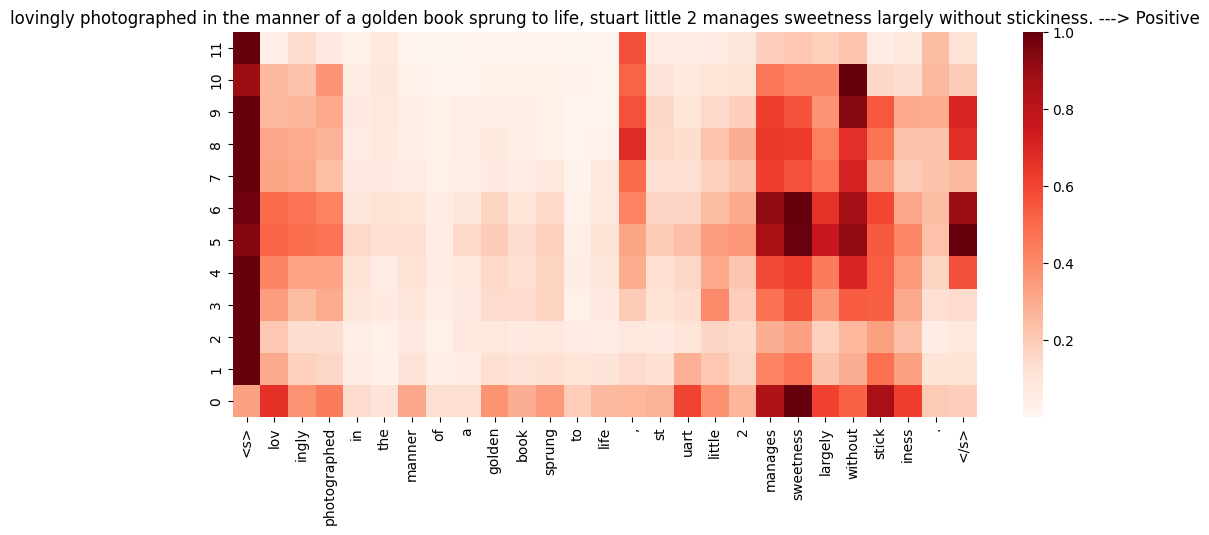

In [ ]:
hmap_visualization(data_1, 0, integ_grad_data_1_step_1, lbl_data_1_step_1)

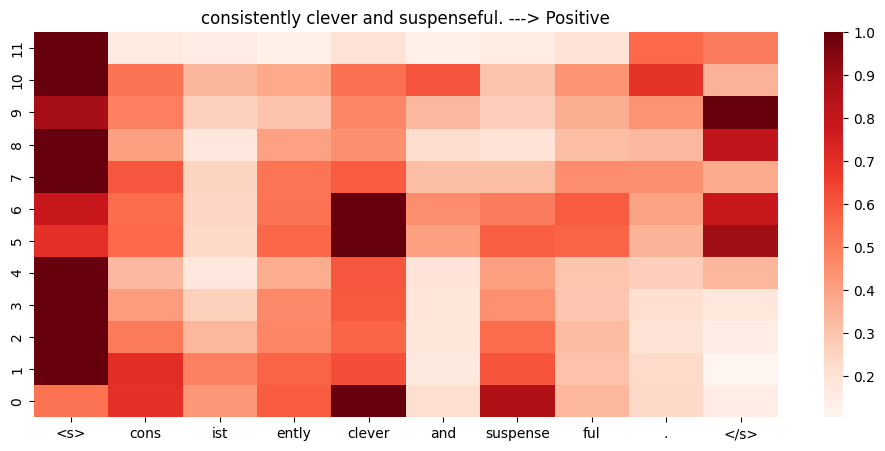

In [ ]:
hmap_visualization(data_1, 1, integ_grad_data_1_step_1, lbl_data_1_step_1)

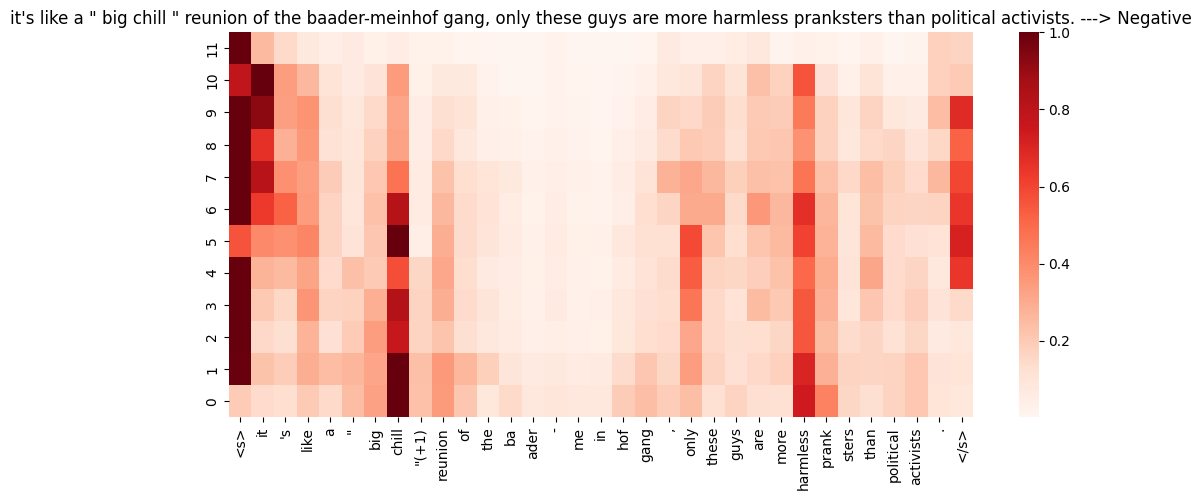

In [ ]:
hmap_visualization(data_2, 0, integ_grad_data_2_step_1, lbl_data_2_step_1)

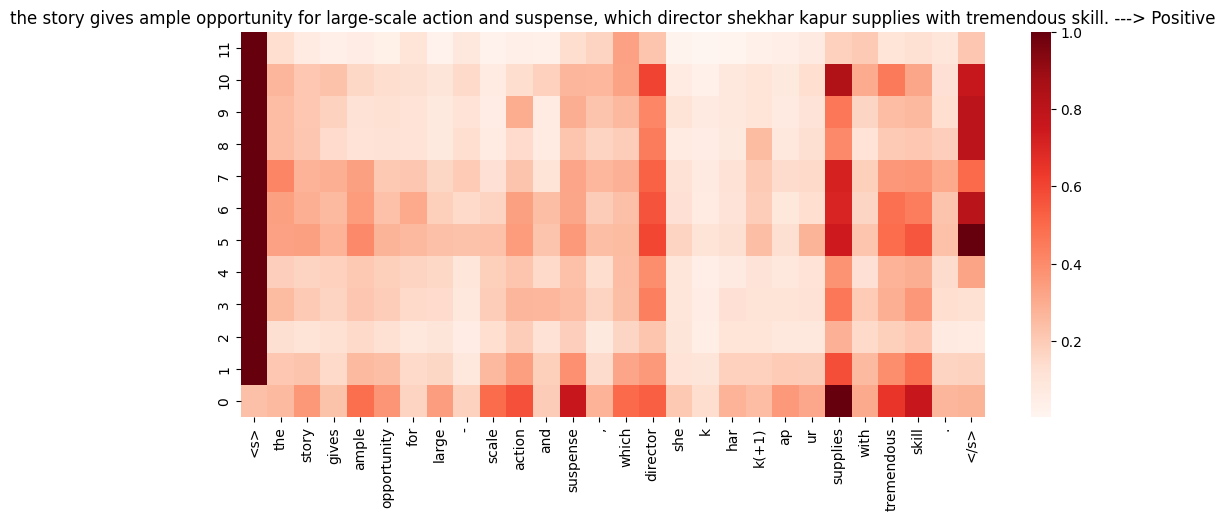

In [ ]:
hmap_visualization(data_2, 1, integ_grad_data_2_step_1, lbl_data_2_step_1)

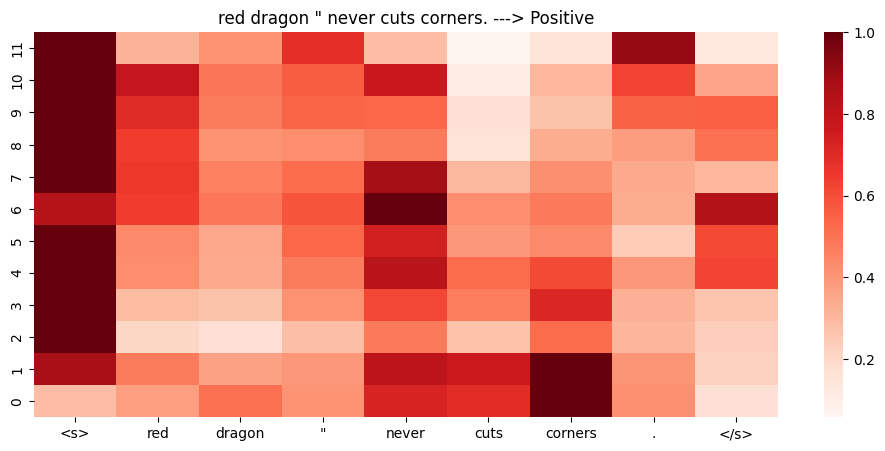

In [ ]:
hmap_visualization(data_3, 0, integ_grad_data_3_step_1, lbl_data_3_step_1)

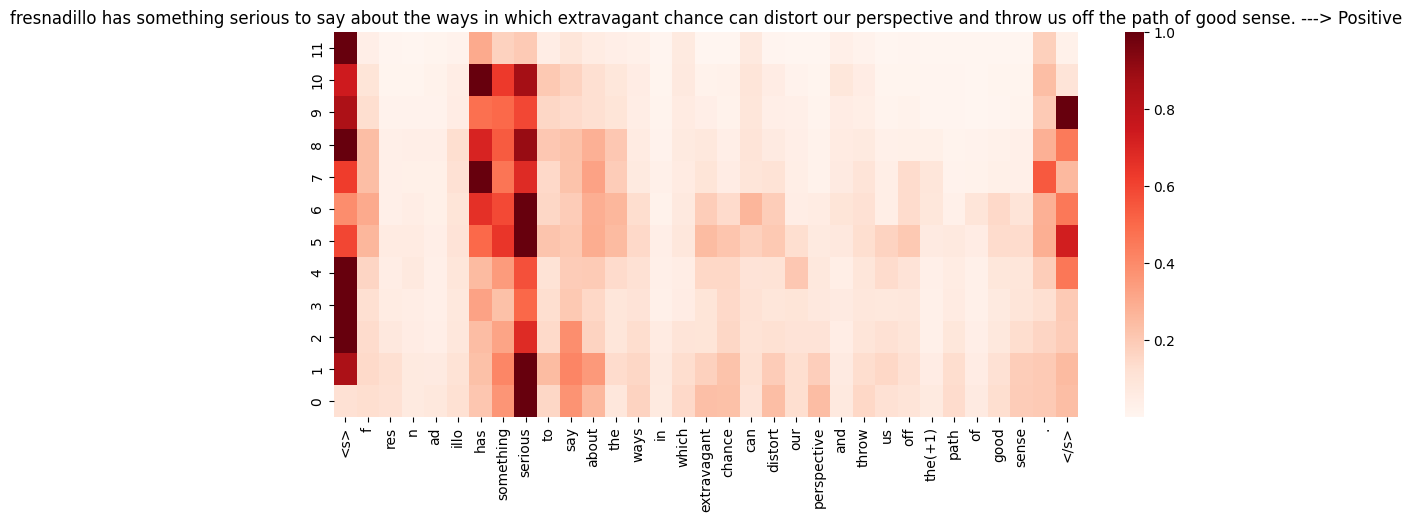

In [ ]:
hmap_visualization(data_3, 1, integ_grad_data_3_step_1, lbl_data_3_step_1)

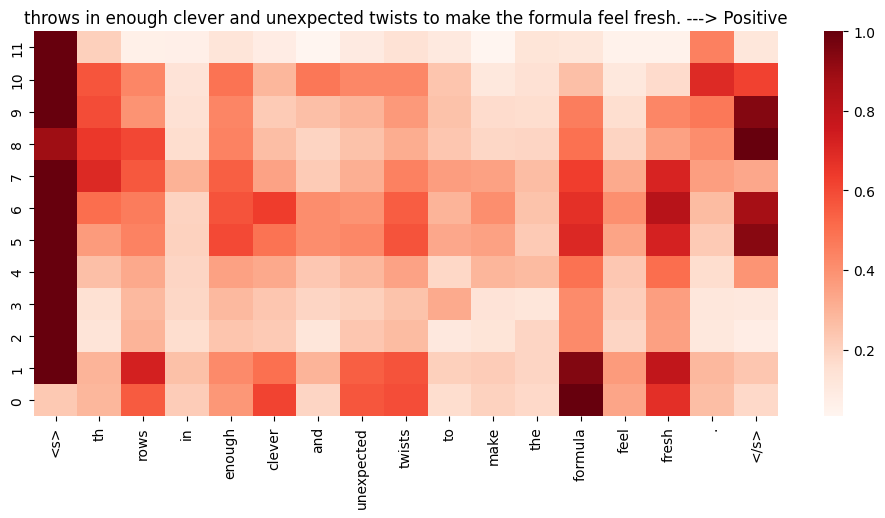

In [ ]:
hmap_visualization(data_4, 0, integ_grad_data_4_step_1, lbl_data_4_step_1)

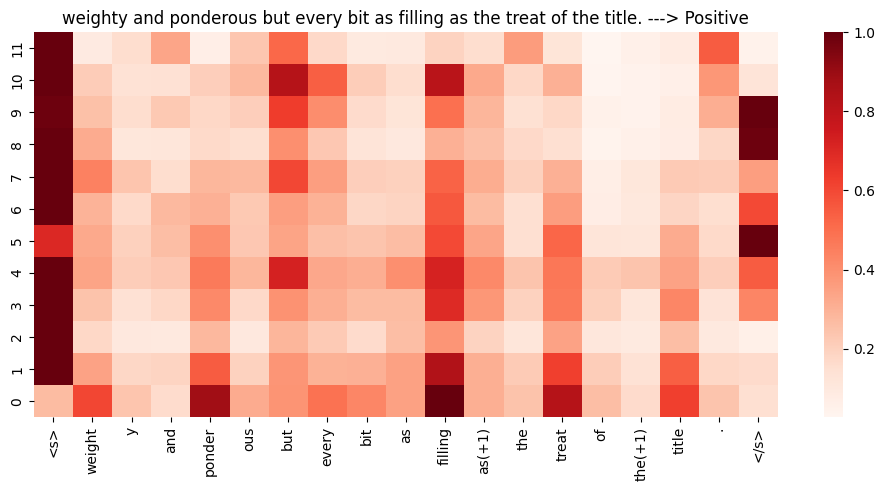

In [ ]:
hmap_visualization(data_4, 1, integ_grad_data_4_step_1, lbl_data_4_step_1)

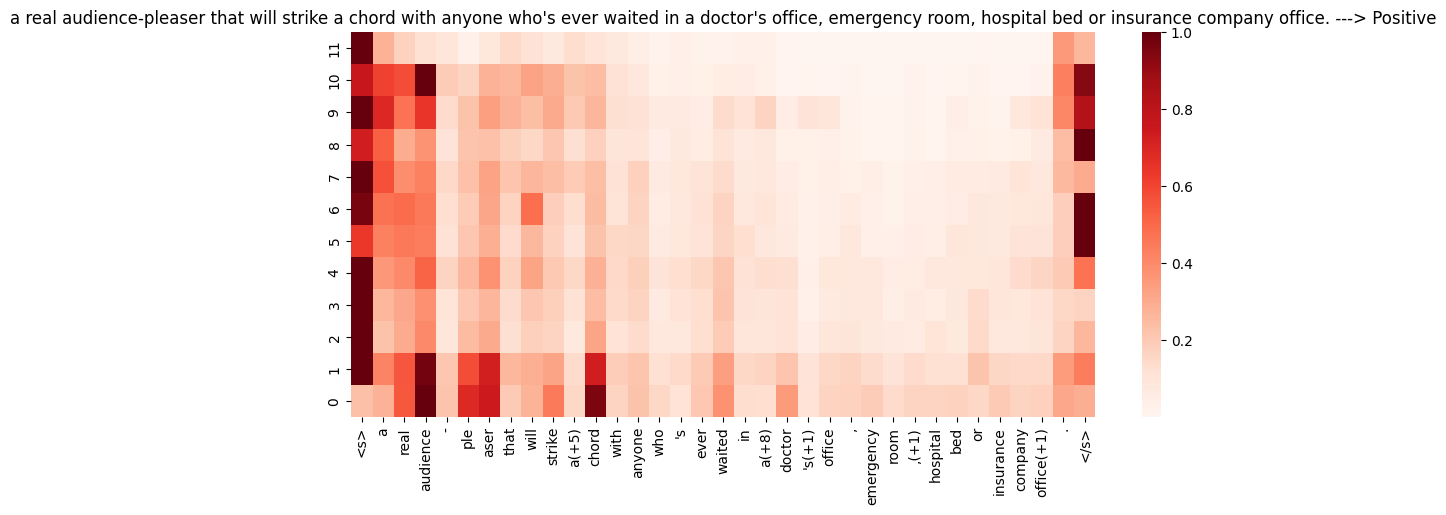

In [ ]:
hmap_visualization(data_5, 0, integ_grad_data_5_step_1, lbl_data_5_step_1)

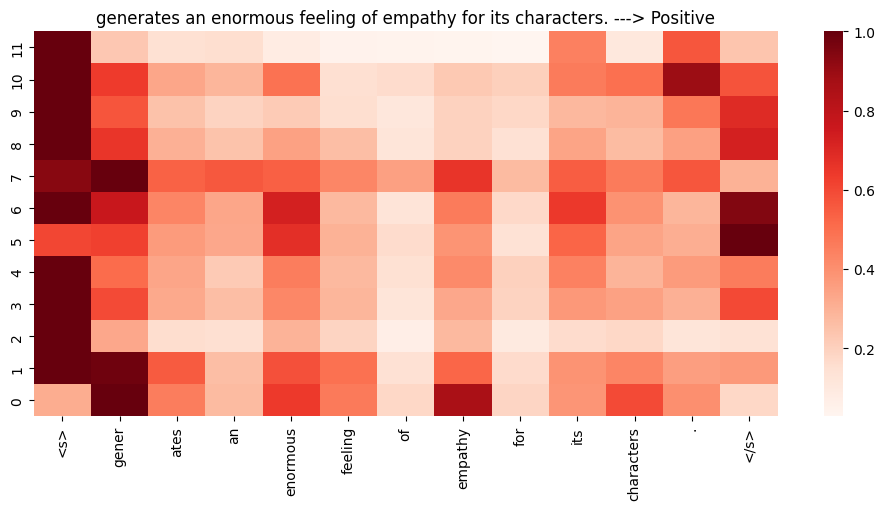

In [ ]:
hmap_visualization(data_5, 1, integ_grad_data_5_step_1, lbl_data_5_step_1)

#### Step = 10

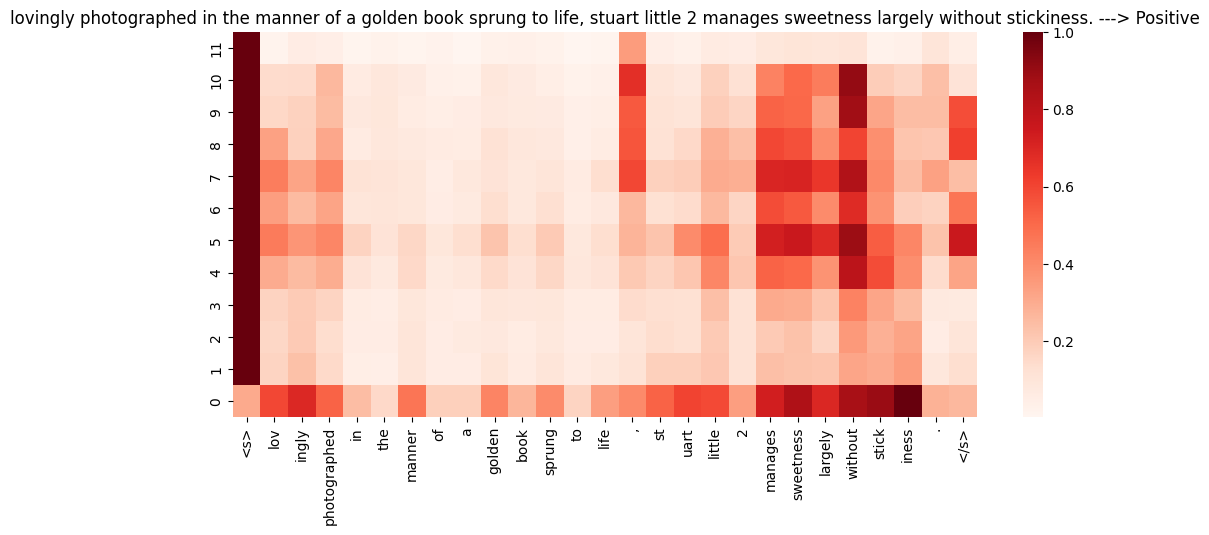

In [ ]:
hmap_visualization(data_1, 0, integ_grad_data_1_step_10, lbl_data_1_step_10)

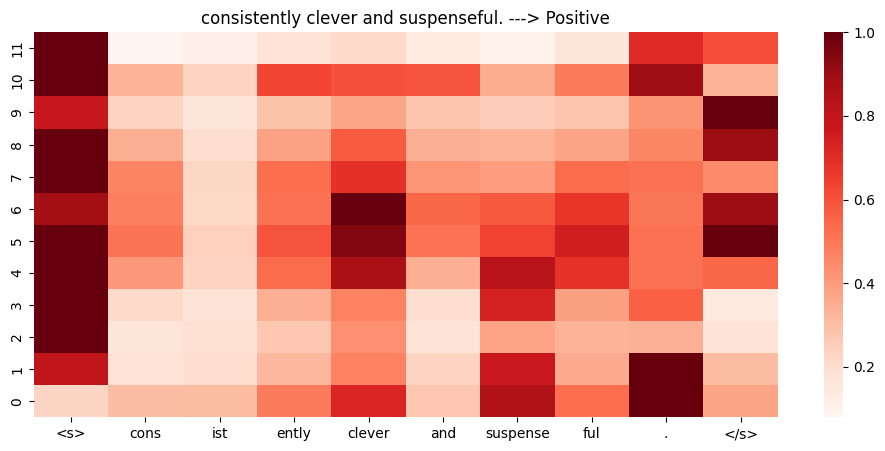

In [ ]:
hmap_visualization(data_1, 1, integ_grad_data_1_step_10, lbl_data_1_step_10)

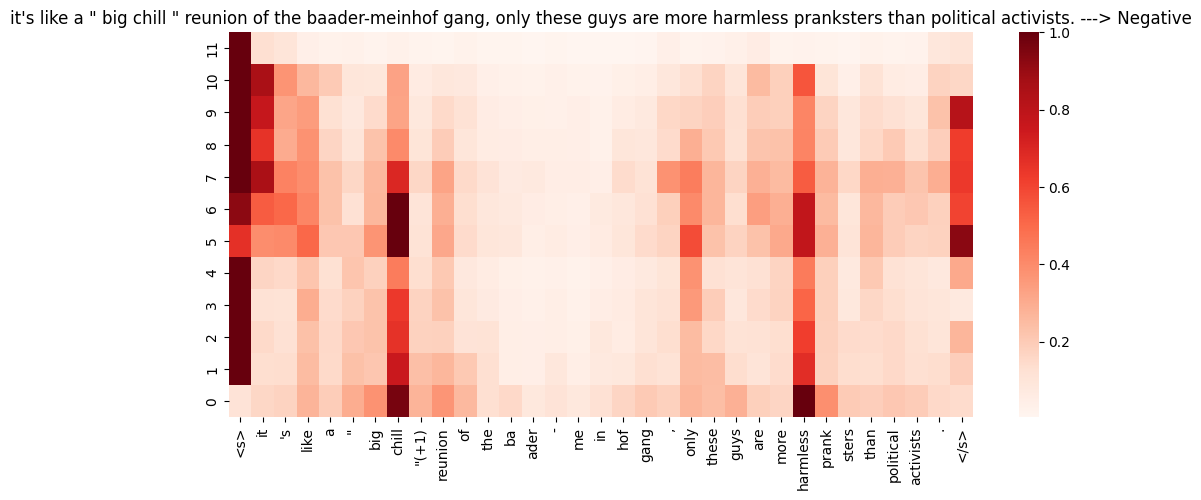

In [ ]:
hmap_visualization(data_2, 0, integ_grad_data_2_step_10, lbl_data_2_step_10)

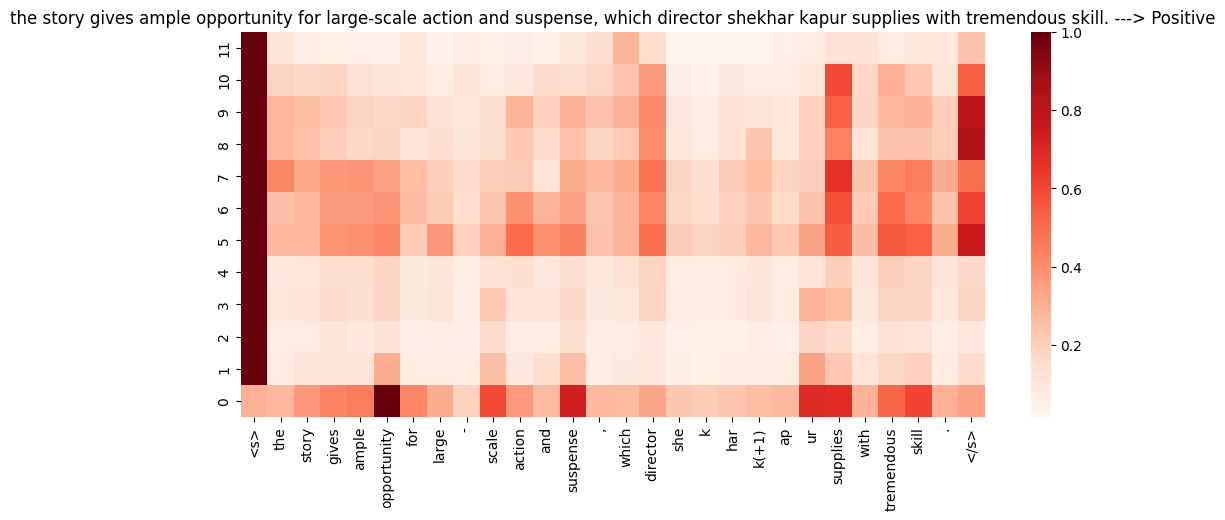

In [ ]:
hmap_visualization(data_2, 1, integ_grad_data_2_step_10, lbl_data_2_step_10)

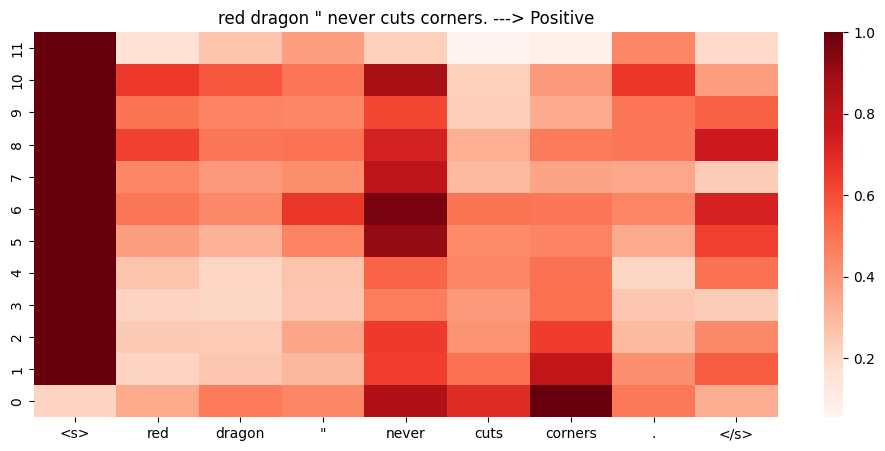

In [ ]:
hmap_visualization(data_3, 0, integ_grad_data_3_step_10, lbl_data_3_step_10)

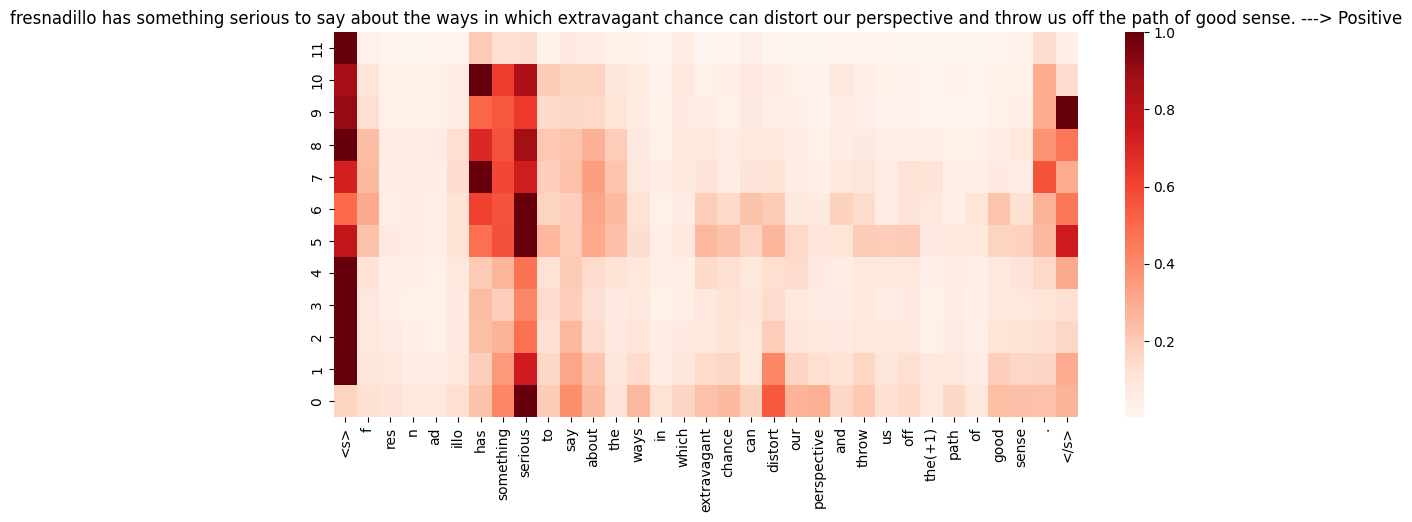

In [ ]:
hmap_visualization(data_3, 1, integ_grad_data_3_step_10, lbl_data_3_step_10)

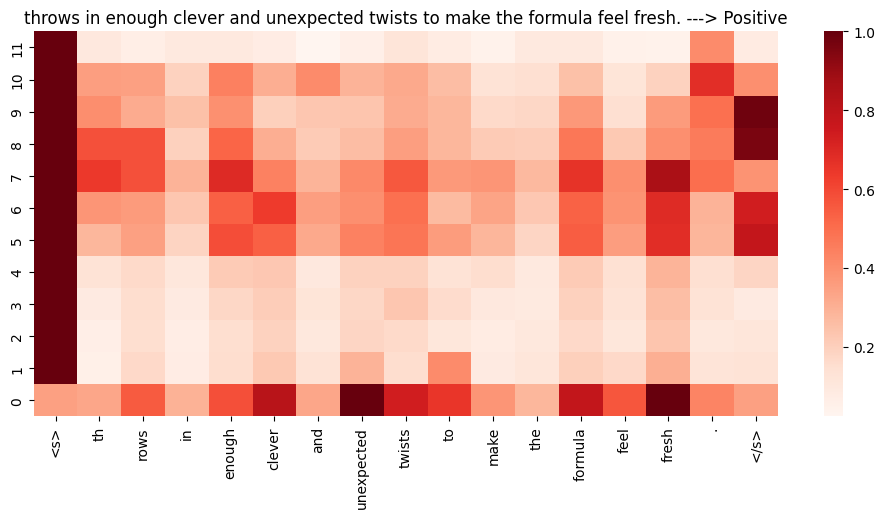

In [ ]:
hmap_visualization(data_4, 0, integ_grad_data_4_step_10, lbl_data_4_step_10)

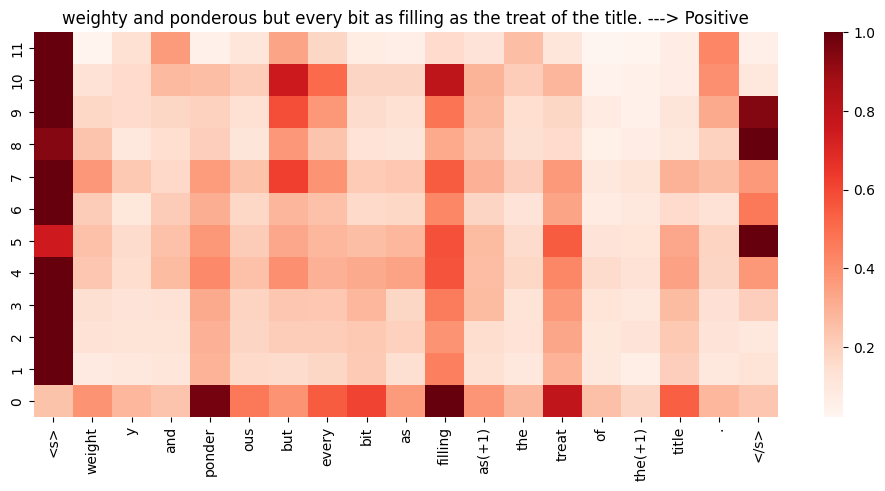

In [ ]:
hmap_visualization(data_4, 1, integ_grad_data_4_step_10, lbl_data_4_step_10)

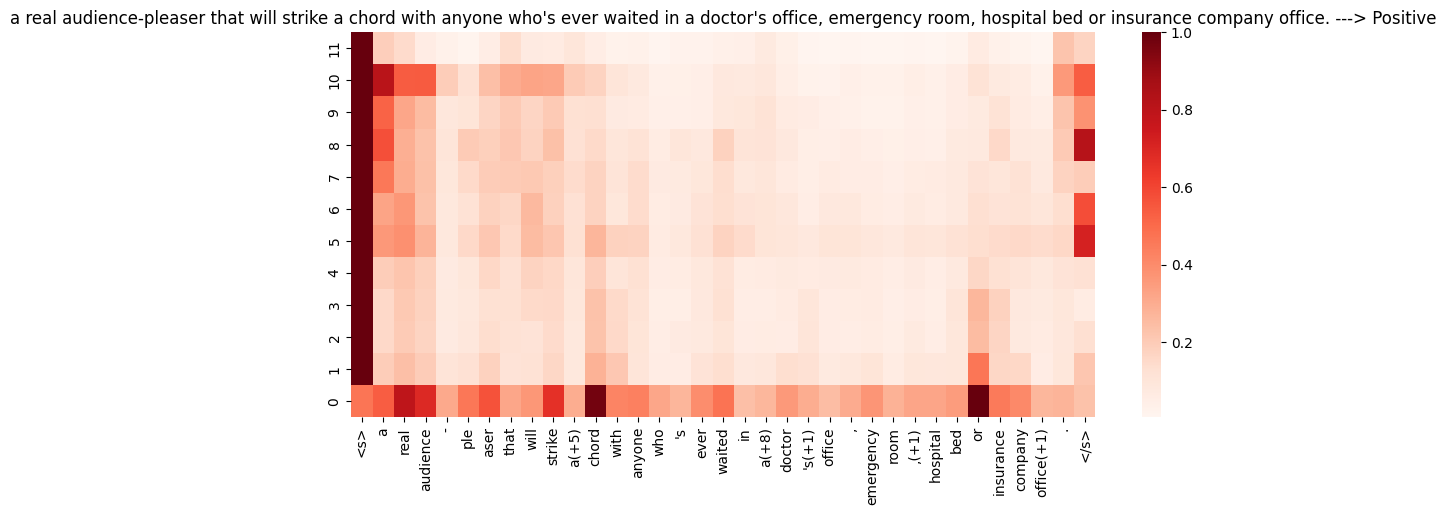

In [ ]:
hmap_visualization(data_5, 0, integ_grad_data_5_step_10, lbl_data_5_step_10)

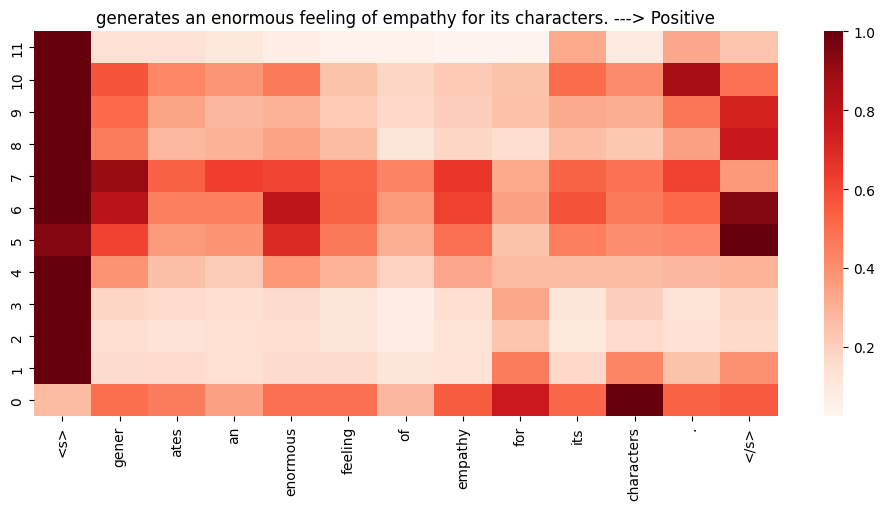

In [ ]:
hmap_visualization(data_5, 1, integ_grad_data_5_step_10, lbl_data_5_step_10)

#### Step = 100

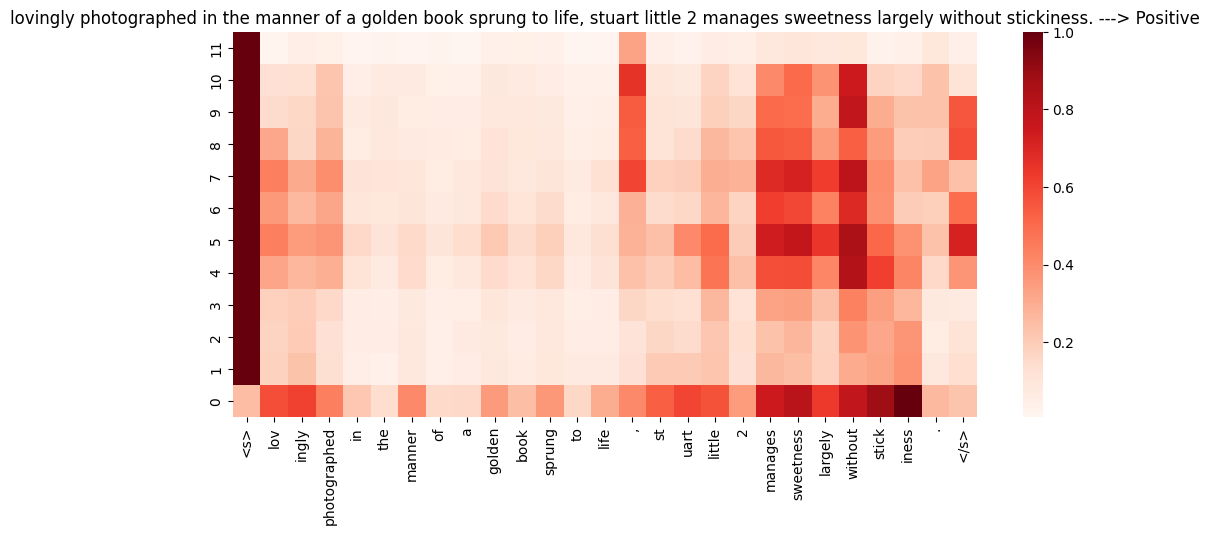

In [ ]:
hmap_visualization(data_1, 0, integ_grad_data_1_step_100, lbl_data_1_step_100)

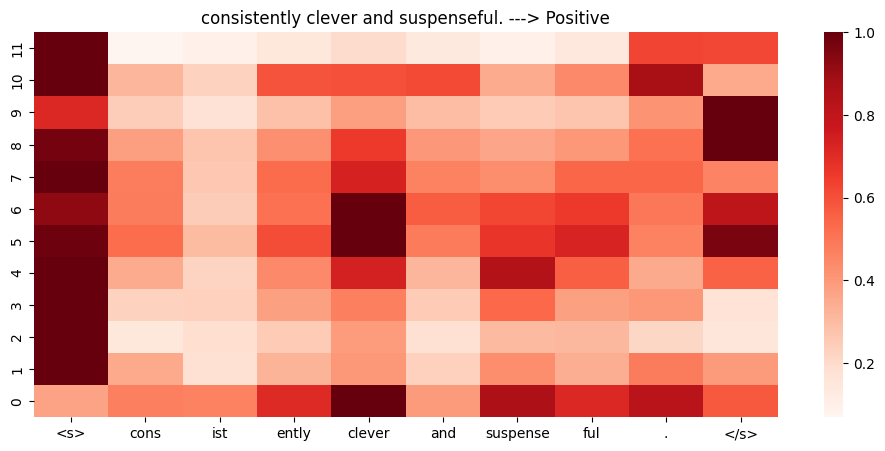

In [ ]:
hmap_visualization(data_1, 1, integ_grad_data_1_step_100, lbl_data_1_step_100)

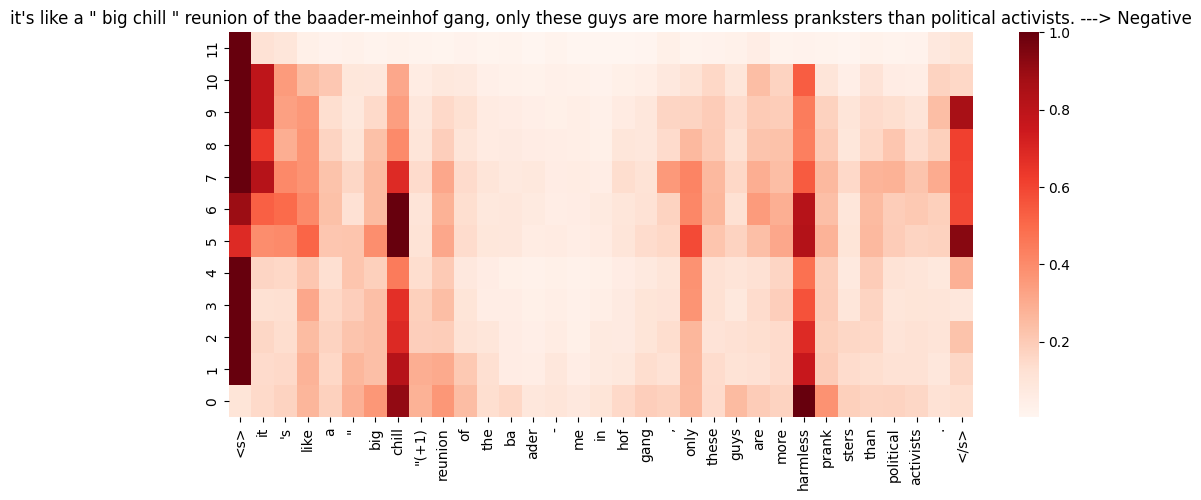

In [ ]:
hmap_visualization(data_2, 0, integ_grad_data_2_step_100, lbl_data_2_step_100)

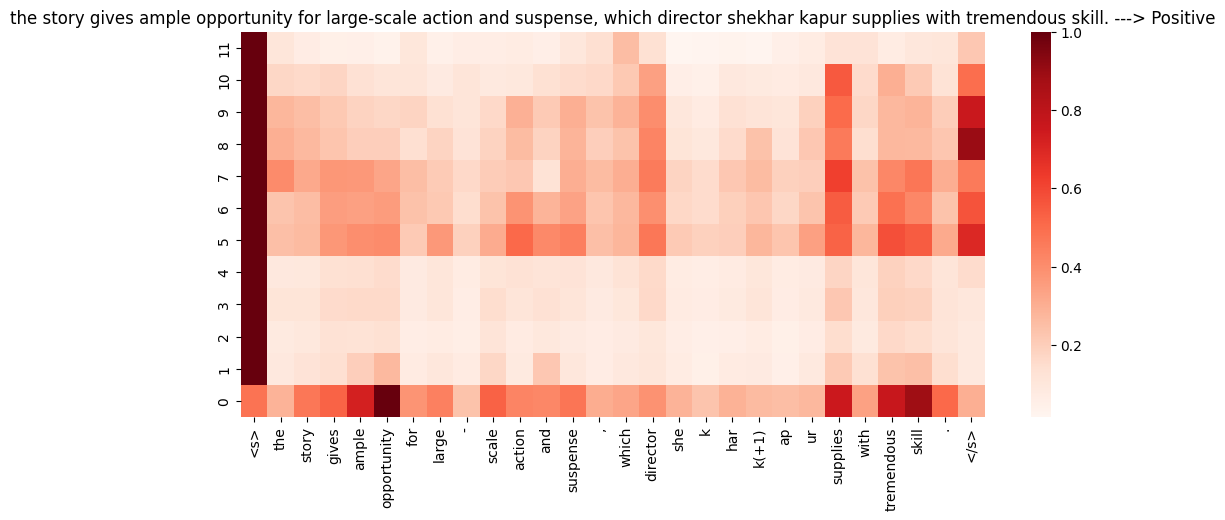

In [ ]:
hmap_visualization(data_2, 1, integ_grad_data_2_step_100, lbl_data_2_step_100)

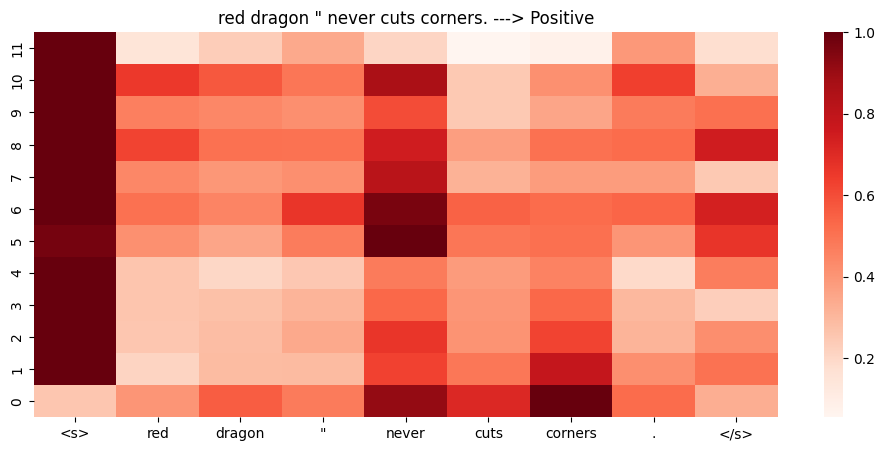

In [ ]:
hmap_visualization(data_3, 0, integ_grad_data_3_step_100, lbl_data_3_step_100)

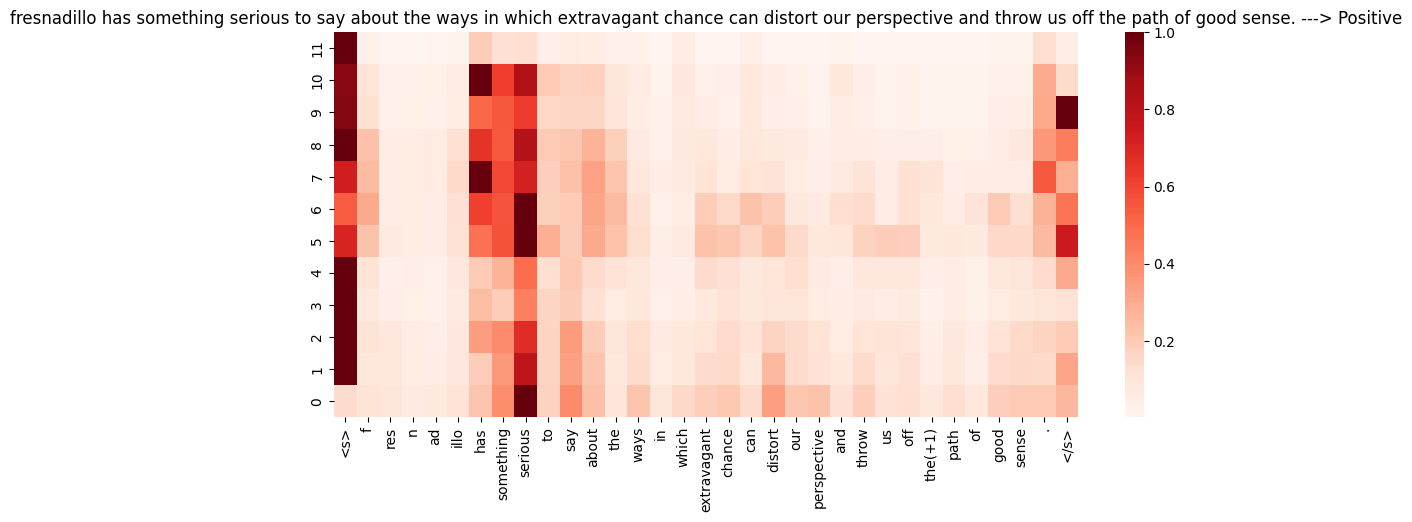

In [ ]:
hmap_visualization(data_3, 1, integ_grad_data_3_step_100, lbl_data_3_step_100)

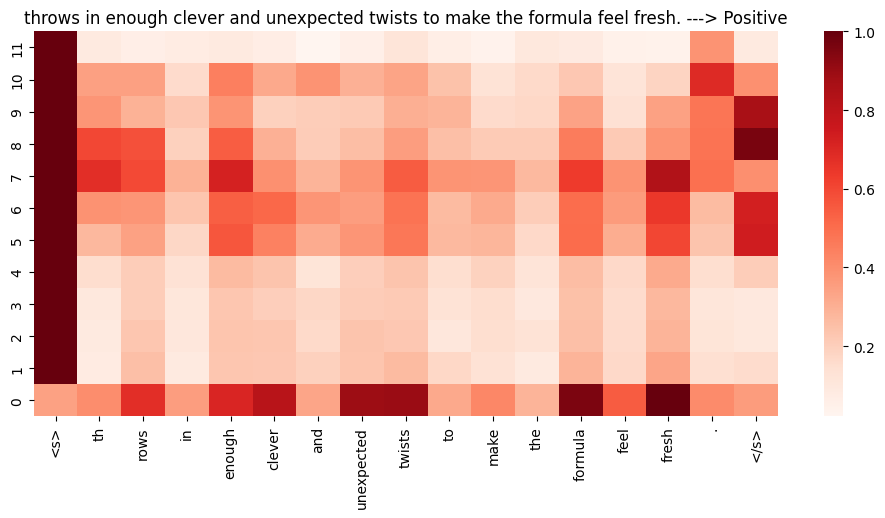

In [ ]:
hmap_visualization(data_4, 0, integ_grad_data_4_step_100, lbl_data_4_step_100)

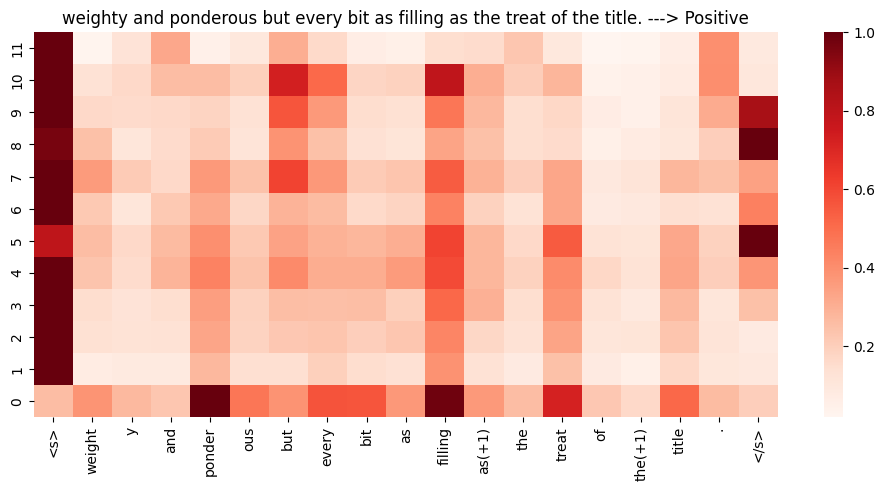

In [ ]:
hmap_visualization(data_4, 1, integ_grad_data_4_step_100, lbl_data_4_step_100)

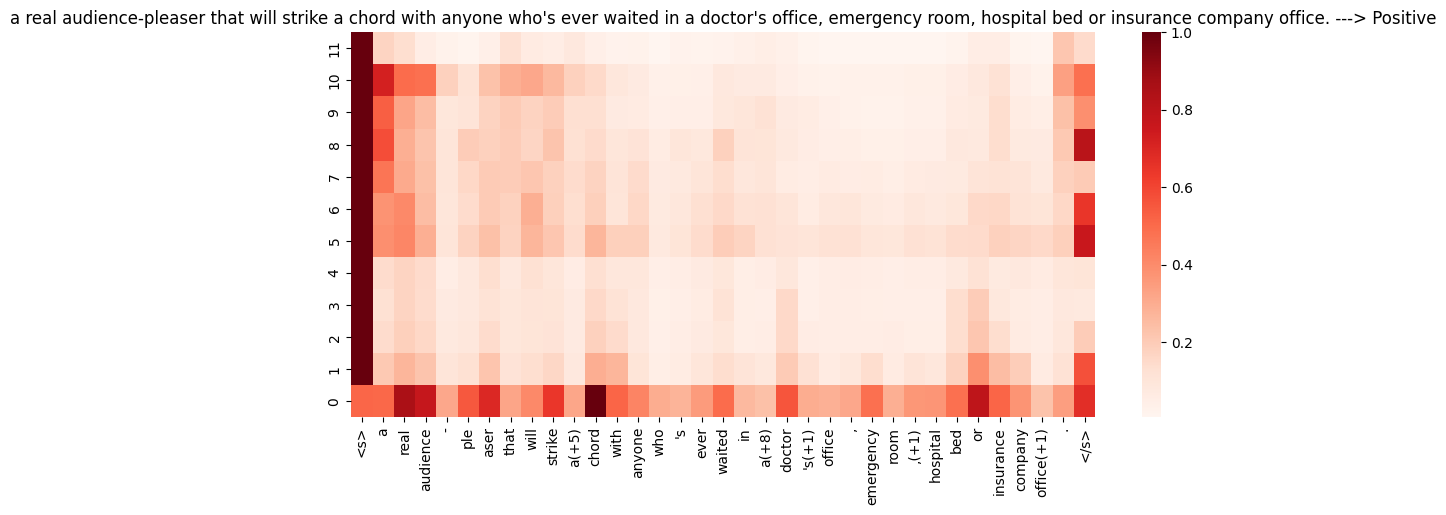

In [ ]:
hmap_visualization(data_5, 0, integ_grad_data_5_step_100, lbl_data_5_step_100)

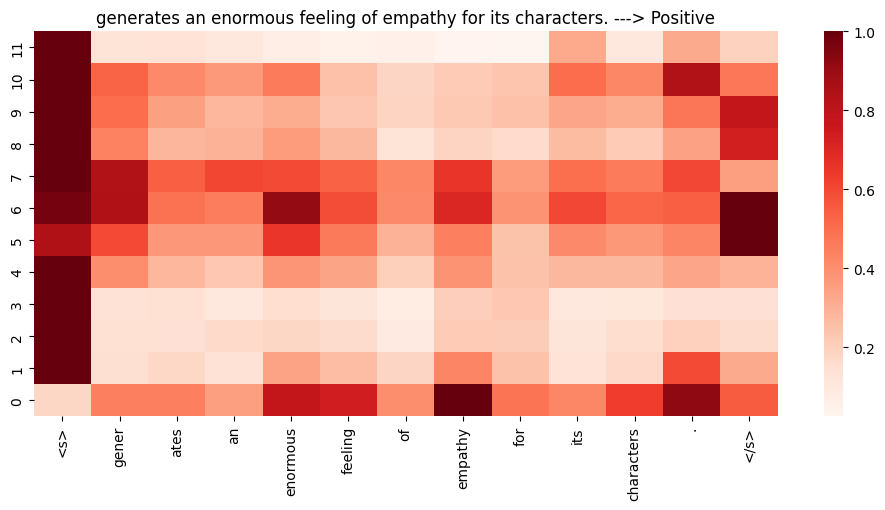

In [ ]:
hmap_visualization(data_5, 1, integ_grad_data_5_step_100, lbl_data_5_step_100)

#### Step = 300

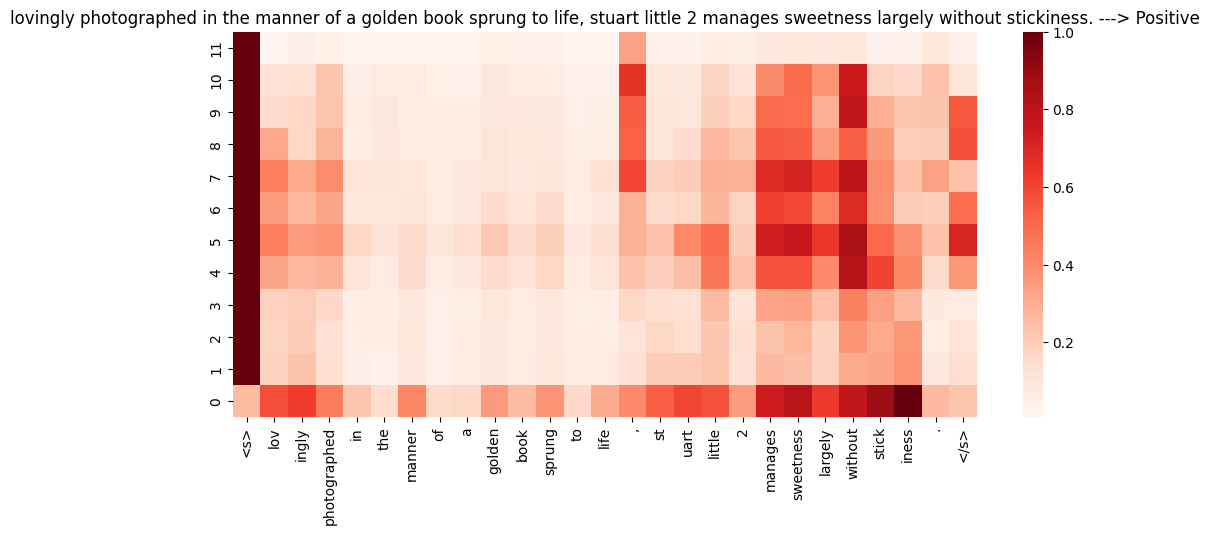

In [ ]:
hmap_visualization(data_1, 0, integ_grad_data_1_step_300, lbl_data_1_step_300)

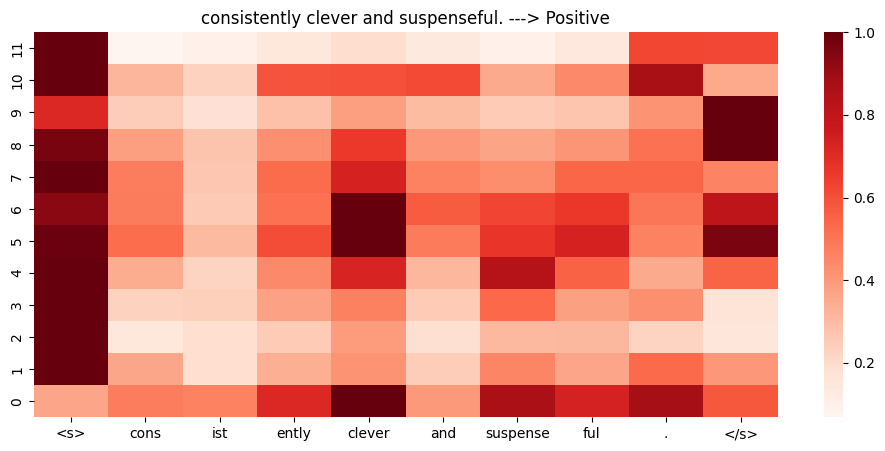

In [ ]:
hmap_visualization(data_2, 0, integ_grad_data_2_step_300, lbl_data_2_step_300)

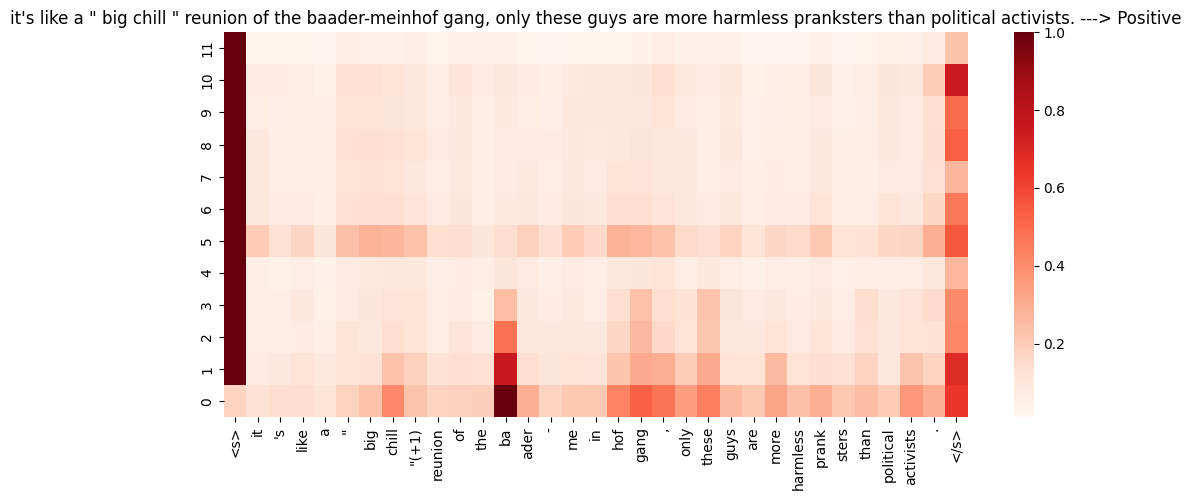

In [ ]:
hmap_visualization(data_3, 0, integ_grad_data_3_step_300, lbl_data_3_step_300)

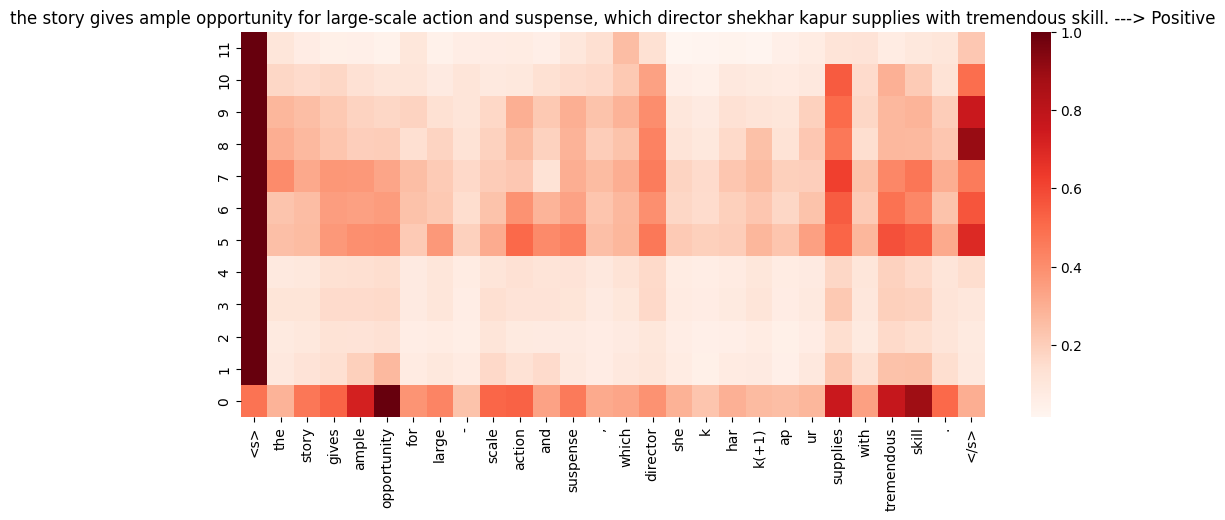

In [ ]:
hmap_visualization(data_4, 0, integ_grad_data_4_step_300, lbl_data_4_step_300)

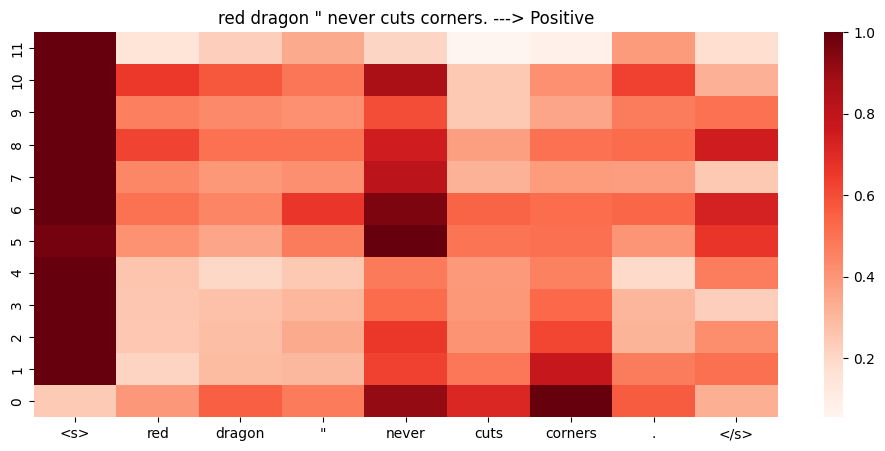

In [ ]:
hmap_visualization(data_5, 0, integ_grad_data_5_step_300, lbl_data_5_step_300)

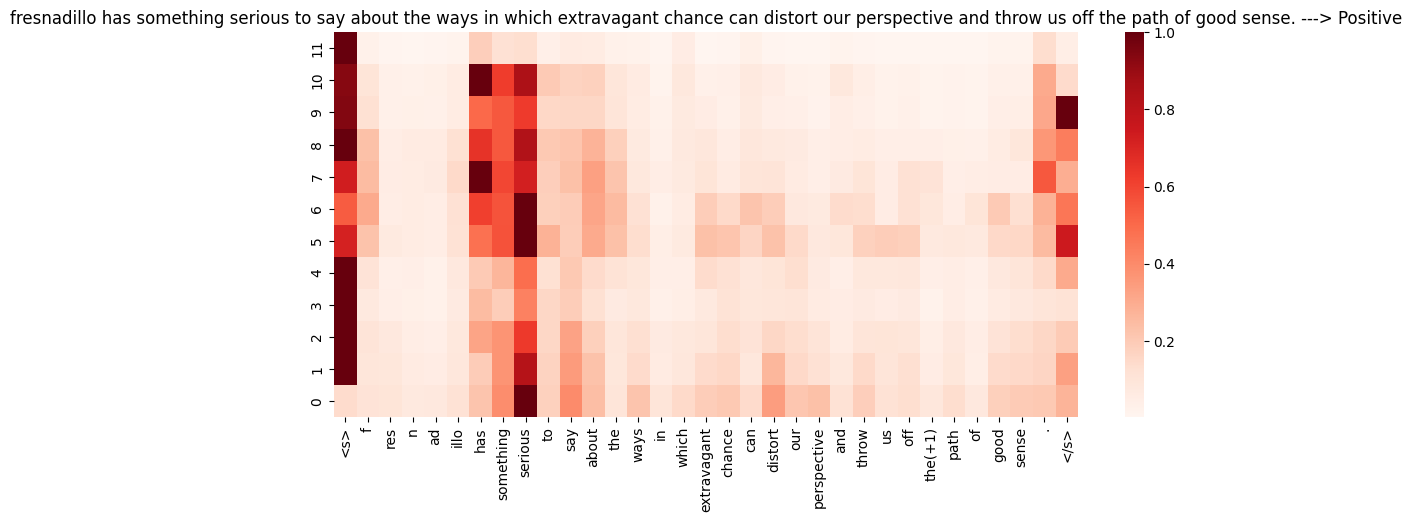

In [ ]:
hmap_visualization(data_6, 0, integ_grad_data_6_step_300, lbl_data_6_step_300)

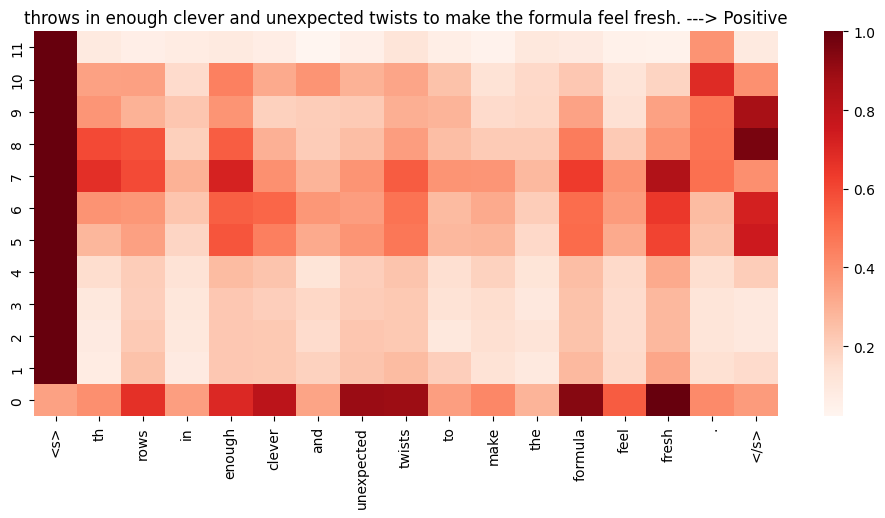

In [ ]:
hmap_visualization(data_7, 0, integ_grad_data_7_step_300, lbl_data_7_step_300)

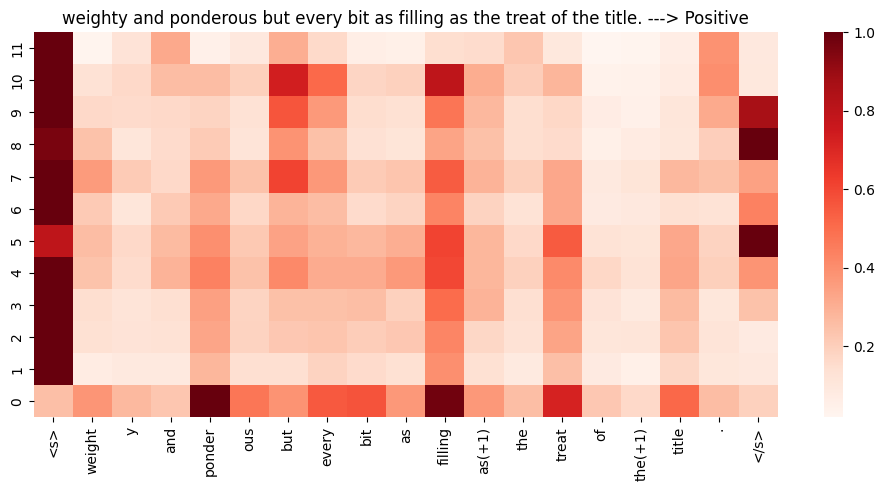

In [ ]:
hmap_visualization(data_8, 0, integ_grad_data_8_step_300, lbl_data_8_step_300)

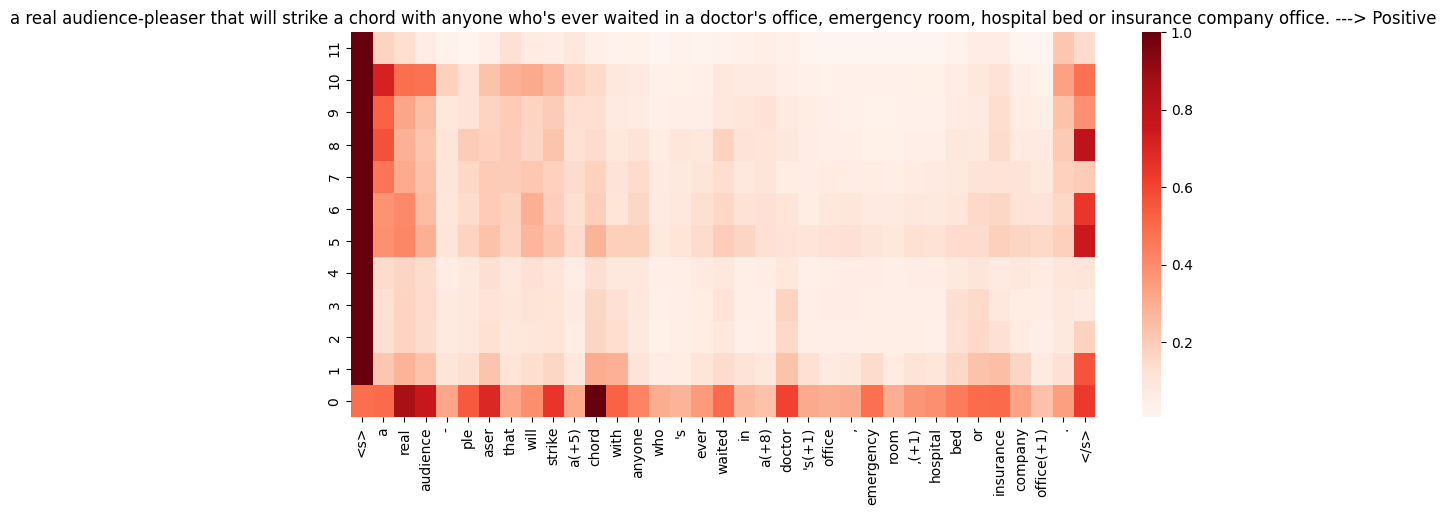

In [ ]:
hmap_visualization(data_9, 0, integ_grad_data_9_step_300, lbl_data_9_step_300)

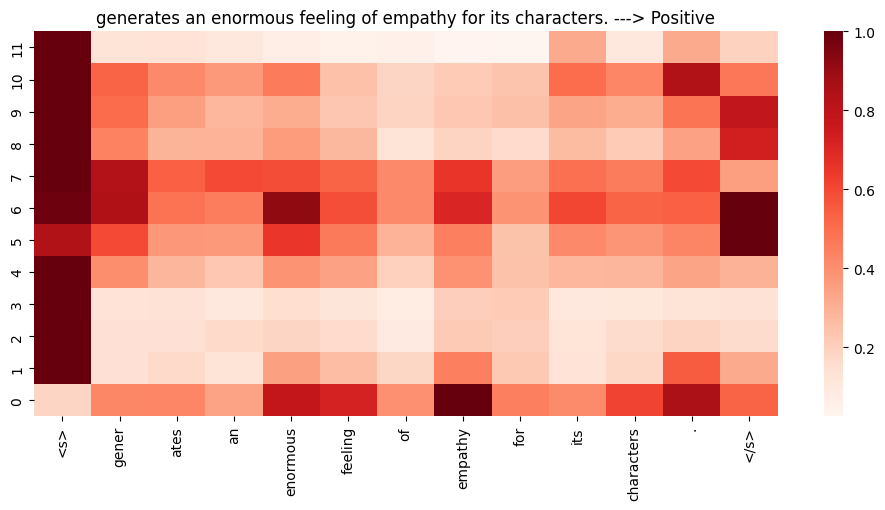

In [ ]:
hmap_visualization(data_10, 0, integ_grad_data_10_step_300, lbl_data_10_step_300)

# Extra

As you can see after the the first hidden layer, attribution is mainly on the `<s>` token and that's because of this fact we use this token as our whole text embedding in order to specify the sentiment of text.

Anothe approach in order to use a head on top of RoBERTa is to get the mean of all tokens in the sequence and account that as the sequence representation.

For this approach we are goin to see 4 sample visualizations.

## The Model

In [ ]:
# Defining RoBERTa model and adding classfication head on top of it
class RobertaClass(nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.bare_roberta = RobertaModel.from_pretrained("roberta-base")
        self.dense = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        try:
            output_1 = self.bare_roberta(inputs_embeds=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        except:
            output_1 = self.bare_roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)

        hidden_state = output_1[0] # last_hidden_state (batch_size, sequence_length, hidden_size)
        # pooler = hidden_state[:, 0] # take only the [CLS] token from last_hidden_state
        pooler = hidden_state[:, 1:].mean(1) # mean of all tokens except the [CLS] token
        pooler = self.dense(pooler)
        pooler = nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output, output_1

In [ ]:
model = RobertaClass()
model.to(device)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/NLP 01 - Dr. Pilehvar/checkpoint.pt'))

## Accuracy

In [ ]:
test_loss, test_acc, preds_list, targets_list = eval_model(model, test_dataloader, test_dataset, criterion)
print(f'Test loss: {test_loss:.3f} | Test acc: {test_acc * 100:.2f}%')

Evaluation:   0%|          | 0/34 [00:00<?, ?it/s]

Test loss: 0.305 | Test acc: 87.90%


Using torchmetrics to calculate remaining metrics.

In [ ]:
!pip install torchmetrics
clear_output()

In [ ]:
from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryF1Score

In [ ]:
# generated prediction and target lists are correct in size
print(len(preds_list))
print(len(targets_list))

1066
1066


In [ ]:
# torchmetrics uses tensors
preds_tensor = torch.tensor(preds_list)
targets_tensor = torch.tensor(targets_list)

In [ ]:
# max for each prediction
preds_tensor_max = torch.max(preds_tensor, 1)

## Precision

In [ ]:
precision_metric = BinaryPrecision()
precision = precision_metric(preds_tensor_max.indices, targets_tensor).item()
print(f'Precision: {precision * 100:.2f}%')

Precision: 90.08%


## Recall

In [ ]:
recall_metric = BinaryRecall()
recall = recall_metric(preds_tensor_max.indices, targets_tensor).item()
print(f'Recall: {recall * 100:.2f}%')

Recall: 85.18%


## F-1 Score

In [ ]:
f1score_metric = BinaryF1Score()
f1score = f1score_metric(preds_tensor_max.indices, targets_tensor)
print(f'F-1 Score: {f1score * 100:.2f}%')

F-1 Score: 87.56%


## Integrated Gradients

In [ ]:
data_1 = dict()
data_1['ids'], data_1['mask'], data_1['token_type_ids'], data_1['targets'] = data['ids'][0:2], data['mask'][0:2], data['token_type_ids'][0:2], data['targets'][0:2]

In [ ]:
data_2 = dict()
data_2['ids'], data_2['mask'], data_2['token_type_ids'], data_2['targets'] = data['ids'][2:4], data['mask'][2:4], data['token_type_ids'][2:4], data['targets'][2:4]

### Step = 100

In [ ]:
integ_grad_data_1_step_100, lbl_data_1_step_100 = integrated_gradients(data=data_1, model=model, num_steps=100)
clear_output()

In [ ]:
integ_grad_data_2_step_100, lbl_data_2_step_100 = integrated_gradients(data=data_2, model=model, num_steps=100)
clear_output()

## Visualization

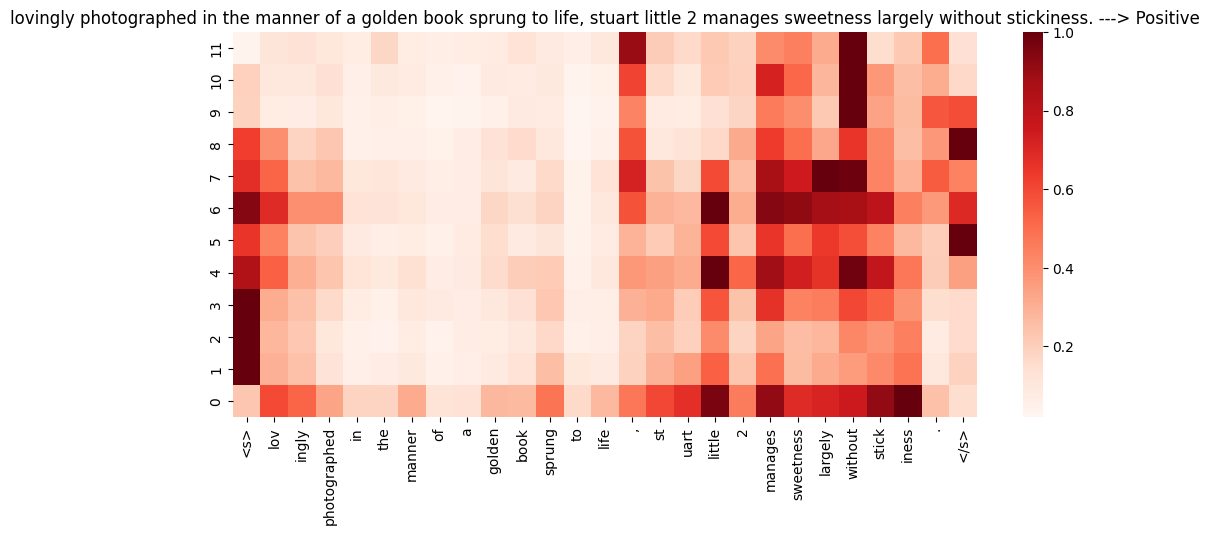

In [ ]:
hmap_visualization(data_1, 0, integ_grad_data_1_step_100, lbl_data_1_step_100)

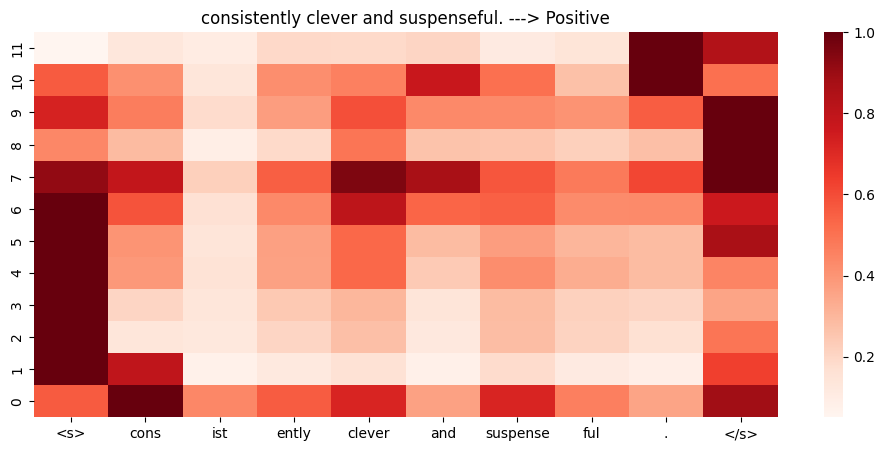

In [ ]:
hmap_visualization(data_1, 1, integ_grad_data_1_step_100, lbl_data_1_step_100)

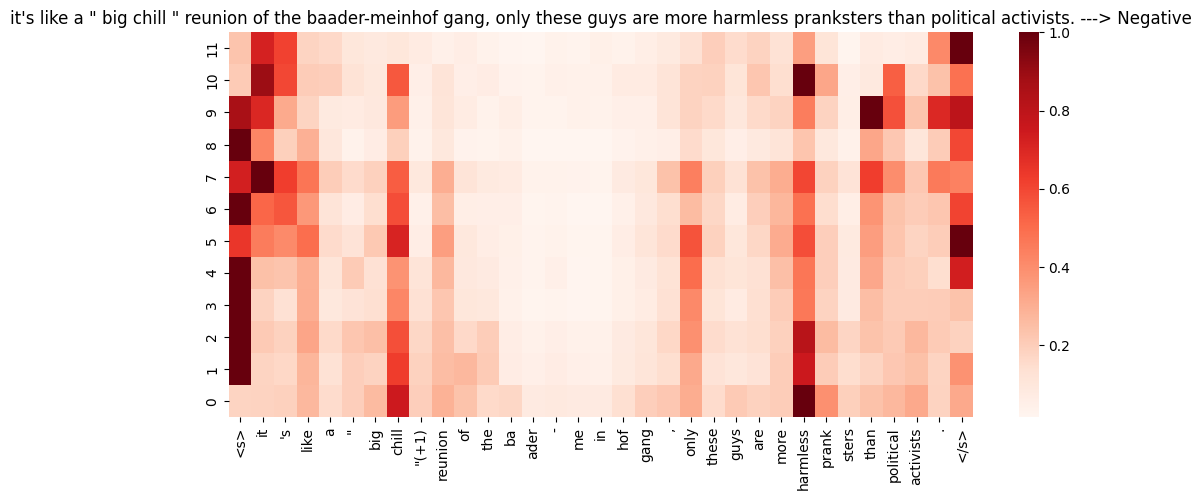

In [ ]:
hmap_visualization(data_2, 0, integ_grad_data_2_step_100, lbl_data_2_step_100)

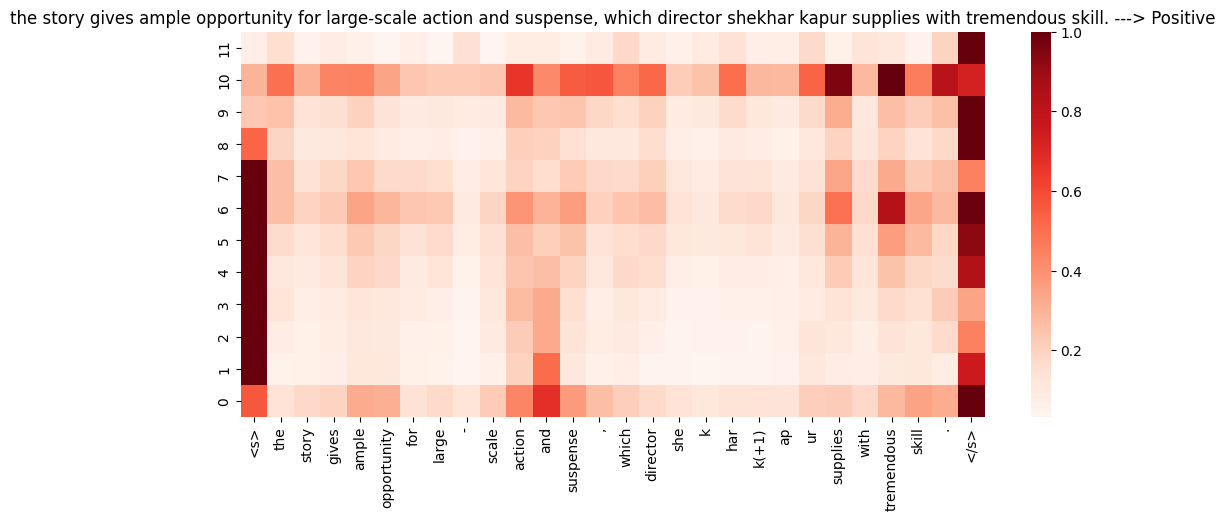

In [ ]:
hmap_visualization(data_2, 1, integ_grad_data_2_step_100, lbl_data_2_step_100)